# <font color="blue"><b> Exploratory Data Analysis</b></font>

---
This notebook contains the same detailed EDA that was submitted for the proposal but with the following differences:
1. The target value which is the *detailed_label* is examined at first, since we know that there are 3 classes of malware traffic with only few entries. Those 3 classes are dropped at this step in order to focus the analysis only to the rest of the classes.
2. The outliers that were identified are also dropped. 
3. Boxplots have been added for the numerical features as suggested.
4. The numerical features are also examined with two scalers. 

The notebook is separated into the following 5 sections: 

1. Structure of data
2. Quality of data
3. Content of data
4. Investigation for replacement of missing values and wrong data entries
5. Feature Engineering (not covered in 3)
6. Summary

*NOTE: The pre-processing steps which are implemented here are only to keep track of the final steps needed in the pre-processing pipeline.*

---

In [1]:
# basic libs
import os
import pandas as pd
import numpy as np

# plot libs
import seaborn as sns
from matplotlib import pyplot as plt, dates
%matplotlib inline

---
### **1. Structure of data**
---

---
#### **1.1 Load data**
---

In [2]:
# Read the merged csv file
data_df = pd.read_csv(os.path.join('data', 'ioT_data.csv'))

# Check a random sample of five entries
data_df.sample(5)

,timestamp,uid,origin_address,origin_port,response_address,response_port,protocol,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed_label
76667,1.526810e+09,CFd1tx4nL0aRkGGVsg,192.168.2.5,56001,182.198.195.28,22,tcp,-,2.991628,0,...,-,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
96148,1.526825e+09,CXpKRP2PZDYG4BQe9,192.168.2.5,51907,196.65.41.181,22,tcp,-,-,-,...,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
196699,1.547130e+09,CNog4E4pjUmM4Ie63g,192.168.1.197,52384,192.168.1.1,53,udp,dns,0.001738,29,...,-,0,Dd,1,57,1,73,-,Benign,-
132622,1.526854e+09,CBF7pI8XU1GS7lve8,192.168.2.5,37956,51.17.10.97,22,tcp,-,-,-,...,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
77136,1.526810e+09,CrBzjt2jh51Tqvbrk,192.168.2.5,58135,182.141.78.18,22,tcp,-,-,-,...,-,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan


---
#### **1.2 Check shape**
---

In [3]:
# Display shape
print('Shape of data:', data_df.shape)

Shape of data: (202765, 23)


> The dataset contains 23 features and 202,765 entries.

---
#### **1.3 Display concise summary**
---

In [4]:
# Display summary
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202765 entries, 0 to 202764
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         202765 non-null  float64
 1   uid               202765 non-null  object 
 2   origin_address    202765 non-null  object 
 3   origin_port       202765 non-null  int64  
 4   response_address  202765 non-null  object 
 5   response_port     202765 non-null  int64  
 6   protocol          202765 non-null  object 
 7   service           202765 non-null  object 
 8   duration          202765 non-null  object 
 9   orig_bytes        202765 non-null  object 
 10  resp_bytes        202765 non-null  object 
 11  conn_state        202765 non-null  object 
 12  local_orig        202765 non-null  object 
 13  local_resp        202765 non-null  object 
 14  missed_bytes      202765 non-null  int64  
 15  history           202765 non-null  object 
 16  orig_pkts         20

> 1. There are both numerical and categorical features.

> 2. At a first glance, it looks like that there are no missing values but they have been replaced by dashed lines ('-') except for missing entries in the addresses that were replaced with '::' <a id = "ref_1">[1]</a>. 

> 3. The type of features are <a id = "ref_1">[1]</a>, <a id = "ref_2">[2]</a>:
    - **timestamp**: the time of the capture in unix timestamp
    - **uid**: a unique identifier of the capture
    - **origin_address**: the IP address where the attack happened, either IPv4 or IPv6
    - **origin_port**: the port used by the responder
    - **response_address**: the IP address of the device on which the capture happened, either IPv4 or IPv6
    - **response_port**: the port used for the response from the device where the capture happened
    - **protocol**: the transport layer protocol used for the data package
    - **service**: an identification of the application protocol being sent over the connection
    - **duration**: the amount of time the connection lasted
    - **orig_bytes**: the number of payload bytes the originator sent
    - **resp_bytes**: he number of payload bytes the responder sent
    - **conn_state**: the state of the connection. Possible values are:
        - **S0**: Connection attempt seen, no reply.
        - **S1**: Connection established, not terminated.
        - **SF**: Normal establishment and termination. Note that this is the same symbol as for state S1. You can tell the two apart because for S1 there will not be any byte counts in the summary, while for SF there will be.
        - **REJ**: Connection attempt rejected.
        - **S2**: Connection established and close attempt by originator seen (but no reply from responder).
        - **S3**: Connection established and close attempt by responder seen (but no reply from originator).
        - **RSTO**: Connection established, originator aborted (sent a RST).
        - **RSTR**: Responder sent a RST.
        - **RSTOS0**: Originator sent a SYN followed by a RST, we never saw a SYN-ACK from the responder.
        - **RSTRH**: Responder sent a SYN ACK followed by a RST, we never saw a SYN from the (purported) originator.
        - **SH**: Originator sent a SYN followed by a FIN, we never saw a SYN ACK from the responder (hence the connection was “half” open).
        - **SHR**: Responder sent a SYN ACK followed by a FIN, we never saw a SYN from the originator.
        - **OTH**: No SYN seen, just midstream traffic (one example of this is a “partial connection” that was not later closed).
    - **local_orig**: whether the connection is originated locally
    - **local_resp**: whether the response is originated locally
    - **missed_bytes**: indicates the number of bytes missed in content gaps, which is representative of packet loss. A value other than zero will normally cause protocol analysis to fail but some analysis may have been completed prior to the packet loss.
    - **history**: records the state history of connections as a string of letters. The meaning of those letters is:
        - **s**: a SYN w/o the ACK bit set
        - **h**: a SYN+ACK (“handshake”)
        - **a**: a pure ACK
        - **d**: packet with payload (“data”)
        - **f**: packet with FIN bit set
        - **r**: packet with RST bit set
        - **c**: packet with a bad checksum (applies to UDP too)
        - **g**: a content gap
        - **t**: packet with retransmitted payload
        - **w**: packet with a zero window advertisement
        - **i**: inconsistent packet (e.g. FIN+RST bits set)
        - **q**: multi-flag packet (SYN+FIN or SYN+RST bits set)
        - **^:** connection direction was flipped by Zeek’s heuristic
        - If the event comes from the originator, the letter is in upper-case; if it comes from the responder, it’s in lower-case. 
    - **orig_pkts**: number of packets that the originator sent
    - **orig_ip_bytes**: number of IP level bytes that the originator sent
    - **resp_pkts**: number of packets that the responder sent
    - **resp_ip_bytes**: number of IP level bytes that the responder sent 
    - **tunnel_parents**: the id of the connection, if tunnelled
    - **label**: the type of capture, benign or malicious
    - **detailed_label**: if the capture is malicious, the type of capture



<br>

> <u>References</u>:

> [[1]](#ref_1) Stoian, N.A. (2020) https://essay.utwente.nl/81979/ 

> [[2]](#ref_2) https://docs.zeek.org/en/master/scripts/base/protocols/conn/main.zeek.html, https://docs.zeek.org/en/master/logs/conn.html

> Before exploring the data further, we can replace the encoded missing entries with nans to have a better idea of the dataset.

---
#### **1.4 Preprocessing step to replace encoding missing entries**
---

In [5]:
# Recover missing entries
def preprocess_step1(input_df):
    
    # Get a copy of the dataframe
    df = input_df.copy()
    
    # Replace '-' with nans
    df = df.replace({'-':np.nan})
    
    # Replace empty IP addresses with nans
    df['origin_address'] = df['origin_address'].replace({'::':np.nan})
    df['response_address'] = df['response_address'].replace({'::':np.nan})   
    
    # Change data type of timestamp and sort entries according to timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') 
    df = df.sort_values(by='timestamp',ascending=True).reset_index(drop=True)    
  
    return df

---
#### **1.5 Check summary after preprocessing**
---

In [6]:
# process dataframe
data_df = preprocess_step1(data_df)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202765 entries, 0 to 202764
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         202765 non-null  datetime64[ns]
 1   uid               202765 non-null  object        
 2   origin_address    202735 non-null  object        
 3   origin_port       202765 non-null  int64         
 4   response_address  202765 non-null  object        
 5   response_port     202765 non-null  int64         
 6   protocol          202765 non-null  object        
 7   service           13235 non-null   object        
 8   duration          101394 non-null  object        
 9   orig_bytes        101394 non-null  object        
 10  resp_bytes        101394 non-null  object        
 11  conn_state        202765 non-null  object        
 12  local_orig        0 non-null       float64       
 13  local_resp        0 non-null       float64       
 14  miss

> From the detailed summary, we can see that:

> - there are 2 features, the **local_orig** and the **local_resp** with only null values which can be dropped.
> - the feature **service** has ~94% of missing values. According to the documentation, those entries were not recognized by the Zeek analysis protocol and can be dropped as it probably does not make sense to replace so many missing values.
> - the features **duration**, **orig_bytes** and **resp_bytes** have the same amount of missing values and are are wrongly encoded as object type. 
> - the **origin_address**, **history**, **tunnel_parents**, **detailed_label** have also missing entries. For the latter, we know from the documentation that this label has only the detailed description of the malicious entries (these are data coming from the CTU-IoT-Malware logfiles were only the malware attacks were labeled).

> So we can check at this point if the missing values correspond to benign entries. 

In [7]:
# Check nulls of detailed label
data_df.loc[data_df['detailed_label'].isna()]['label'].value_counts()

Benign    19736
benign     1956
Name: label, dtype: int64

From the above we see that:
> - the missing values of the detailed labels correspond only to benign entries 
> - the benign labels are encoded with both small and capital first letter

We can proceed by:
> - dropping the 2 null features and the service with 94% of missing entries 
> - correcting the type of *duration*, *orig_bytes* and *resp_bytes* to numeric
> - correcting the labels and the detailed labels

---
#### **1.6 Further preprocessing step**
---

In [8]:
# Drop local_orig and local_resp
def preprocess_step2(input_df):
    
    # Get a copy of the dataframe
    df = input_df.copy()
    
    # Drop columns
    df = df.drop(['local_orig','local_resp', 'service'], axis=1)
    
    # Change data type 
    df['duration'] = df['duration'].astype('float') 
    df['orig_bytes'] = df['orig_bytes'].astype('float')
    df['resp_bytes'] = df['resp_bytes'].astype('float')
    
    # Correct labels and detailed labels
    df['label'] = df['label'].replace({'benign':'Benign'})
    df['detailed_label'] = df['detailed_label'].fillna('Benign')     
    
    
    return df

In [9]:
# Process dataframe
data_df = preprocess_step2(data_df)

---
#### **1.7 Check target values**

---

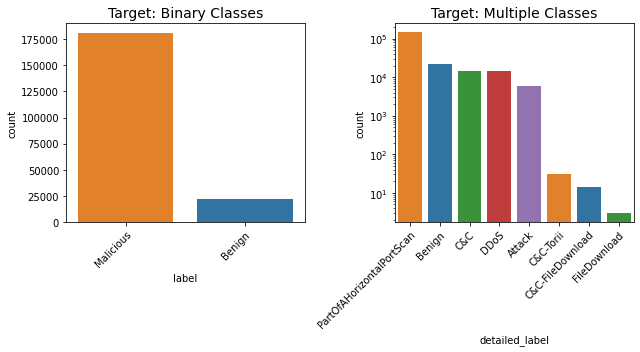

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 5))

# Binary classes
sns.countplot(x="label", data=data_df, order=data_df['label'].value_counts().sort_values(ascending=False).index,
              palette=['tab:orange', 'tab:blue'], ax=ax[0])
ax[0].set_title('Target: Binary Classes', fontsize=14)
xlabels = data_df['label'].value_counts().sort_values(ascending=False).index
ax[0].set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

# Mutliple classes
sns.countplot(x="detailed_label", data=data_df, order = data_df['detailed_label'].value_counts().sort_values(ascending=False).index,
              palette=['tab:orange', 'tab:blue', 'tab:green', 'tab:red', 'tab:purple'], ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Target: Multiple Classes', fontsize=14)
xlabels = data_df['detailed_label'].value_counts().sort_values(ascending=False).index
ax[1].set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

plt.tight_layout()
plt.show()

> Both binary and multiple classes are highly imbalanced. 
> - For binary classification the benign entries cover only ~15% of the total entries while the malicious ones cover the ~85%. 
> - For multiclass classification the horizontal port scans is the majority class with ~1e5 entries while benign, C&C, DDos and Attack have each one of the order of ~1e4 entries. The 3 classes: C&C-Torii, C&C-FileDownload and FileDownload have only few entries each, which are less than 30 and those 3 classes can be dropped. 

---
#### **1.8 Preprocessing step to drop the minority classes**
---

In [11]:
# Drop low entries classes
def preprocess_step3(input_df):
    
    # Get a copy of the dataframe
    df = input_df.copy()
    
    classes_to_drop = ['C&C-Torii', 'C&C-FileDownload', 'FileDownload']

    for label in classes_to_drop:
        mask = df.loc[df['detailed_label']==label].index
        df = df.drop(df.index[[mask]], axis=0)
        df = df.reset_index(drop=True)      
    
    
    return df

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get initial number of entries before dropping the minority classes
entries_init = data_df.shape[0]

# Process dataframe
data_df = preprocess_step3(data_df)

# Get number of entries after dropping the minority classes
entries_reduced = data_df.shape[0]
print('Number of entries from the 3 minority classes:',entries_init-entries_reduced )
print('Number of entries after dropping minority classes:', entries_reduced)

Number of entries from the 3 minority classes: 47
Number of entries after dropping minority classes: 202718


---
#### **1.9 Descriptive Statitics**

---

**1.9.1 Categorical Features**

---

In [13]:
# Get descriptive statistics
data_df.select_dtypes(include='object').describe().T

,count,unique,top,freq
uid,202718,202718,CkS0IAbkihgU5yLCa,1
origin_address,202688,1001,192.168.2.5,154886
response_address,202718,64437,200.168.87.203,23295
protocol,202718,3,tcp,186360
conn_state,202718,12,S0,165236
history,201375,132,S,160192
tunnel_parents,166506,1,(empty),166506
label,202718,2,Malicious,181026
detailed_label,202718,5,PartOfAHorizontalPortScan,145719


> At a first glance we see that:
>   - The **unique identifier** has no duplicate entries as expected. However it is a feature that does not contain any valueable information and can be dropped.
>   - The feature **'tunnel_parents'** has only 1 unique entry, the string "(empty)", thus this feature can also be dropped. 

> For the rest of the features, there are:
>   - **1001** unique **origin IP addresses**. The **top address 192.168.2.5** has a very high frequency appearing in ~75% of the non-null entries.
>   - **64437** unique **response IP addresses**. The **top address 200.168.87.203**  has a rather low frequency of ~10%.
>   - **3** types of **protocols** with the **TCP** covering ~90% of the total entries.
>   - **12** unique **connection states** with the top one **S0** covering ~80% of the total entries.
>   - **132** unique **histories** with the top one **S** covering ~80% of the non null entries.

> We can proceed by dropping the features **uid** and **tunnel_parents**.

---
**Next Preprocessing step**

---

In [14]:
# Drop uid and tunnel parents and correct labels
def preprocess_step4(input_df):
    
    # Get a copy of the dataframe
    df = input_df.copy()
    
    # Drop column
    df = df.drop(['uid','tunnel_parents'], axis=1)
    
    return df

In [15]:
# Preprocess dataframe
data_df = preprocess_step4(data_df)

---
**1.9.2 Numerical features**

---

---
**Descriptive statistics and boxplots**

---

In [16]:
# Display descriptive statistics
data_df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
origin_port,202718.0,45551.301656,1.421047e+04,0.000000,38818.000000,47314.000000,55026.000000,6.527900e+04
response_port,202718.0,7165.272822,1.891336e+04,0.000000,22.000000,22.000000,80.000000,6.379800e+04
duration,101361.0,7.985239,4.941153e+02,0.000001,2.991507,2.995012,2.998278,9.328003e+04
orig_bytes,101361.0,18111.108207,5.485623e+06,0.000000,0.000000,0.000000,0.000000,1.744830e+09
resp_bytes,101361.0,3533.158355,1.057075e+06,0.000000,0.000000,0.000000,0.000000,3.365164e+08
missed_bytes,202718.0,0.343714,4.043597e+01,0.000000,0.000000,0.000000,0.000000,7.363000e+03
orig_pkts,202718.0,10.049384,2.912255e+03,0.000000,1.000000,1.000000,3.000000,1.305034e+06
orig_ip_bytes,202718.0,9426.026983,3.960122e+06,0.000000,60.000000,68.000000,180.000000,1.781371e+09
resp_pkts,202718.0,1.944381,5.324485e+02,0.000000,0.000000,0.000000,0.000000,2.394840e+05
resp_ip_bytes,202718.0,1870.680793,7.765818e+05,0.000000,0.000000,0.000000,0.000000,3.496187e+08


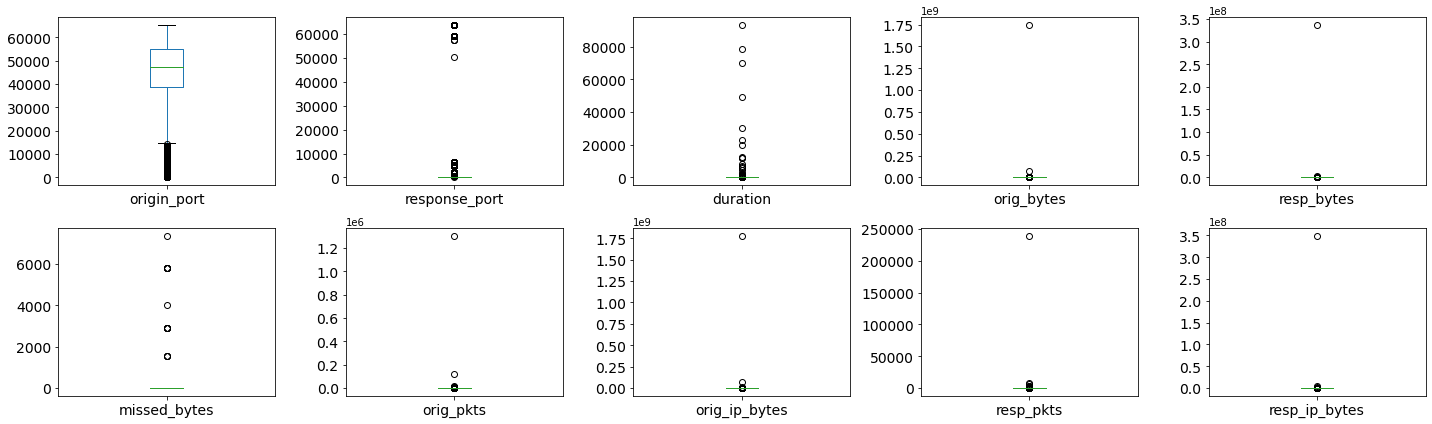

In [17]:
# Draw boxplots
data_df.plot.box(subplots=True, layout=(-1, 5), figsize=(20, 6), fontsize=14)
plt.tight_layout()
plt.show()

> From the descriptive statistics and the boxplots we see:
> - The **origin_port** and **response_port** span from 0 up to ~65,000.
>    - Most of the origin ports used, are in the range ~40,000 - 55,000 while for the origin ports there are mainly small numbers used (<100) up to the 75th percantile. 
> - The rest of the numerical features have up to the 75th percantile values that are rather low while the max values are quite large. In particular:
>    - The **duration** spans from microseconds up to tens of milliseconds.
>    - The number of **bytes** or **ip_bytes** send by the originator or the receiver spans from 0 up to a few GBs.
>    - The number of **missing bytes** spans from 0 up to few tens of thousands. 
>    - The number of **packets** send by the originator or the receiver spans from 1 or 0, respectively, up to a few millions. 

> We can also check the unique values per numerical features at this point. 

---
**Unique values per numerical feature**

---

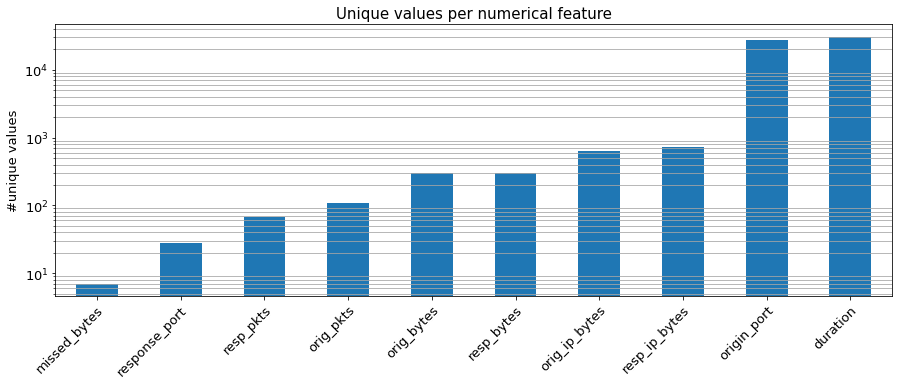

In [18]:
# Check unique values per numerical feature
data_df.select_dtypes(include='number').nunique().sort_values().plot.bar(logy=True, figsize=(15, 5), fontsize=13)
plt.title('Unique values per numerical feature', fontsize=15)                                                                                                 
plt.grid(True, which="minor", ls="-", color='0.65')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.ylabel('#unique values', fontsize=13)
plt.show()

> From the above plot we see that:
>   - the **duration** is a continuous feature with ~30,000 different values.
>   - there are ~30,000 different **origin_ports** while there are only ~20 **response_ports**. This could already reveal the use of the origin ports as for e.g. in a port scan.
>   - the **ip_bytes** send from the originator or the receiver have ~700 and ~600 unique entries respectively while the corresponding **bytes** have about half unique entries. 
>   - the **packets** send from the originator have a bit more than 100 unique values while those send by the responder are a bit less than 100.
>   - the **missing bytes** have a bit more than 10 unique entries.

<div class="alert alert-block alert-success">    
<b>Summary from the structure inverstigation</b> 
<hr>    
 
Up to now, we have seen that the target classes are highly imbalanced. In particular:
- ~85% of the total entries belong to malicious entries. 
- ~80% of the malicious entries belong to an horizontal port scan. 
    
We have also seen that:    
- ~80% of the data have a connection state "S0" (connection attempt seen, no reply) and history labeled with "S" (a SYN w/o the ACK bit set). 
- there are ~1,000 origin IP addresses, ~30,000 origin ports, ~64,000 response IP addresses and ~20 response ports. 

The fact that there are many different response IP addresses reveals an horizontal scanning where requests are send to the same port on different hosts (https://encyclopedia.kaspersky.com/glossary/port-scanning/). However, there are also many different origin ports, which either reveals a vertical scanning (requests are send to different ports on the same host) or another type of malware attack.  This needs to be further inverstigated as we might have incorrect labels.
</div>

---
### **2. Quality of data**
---

---
#### **2.1 Overview of missing values**
---

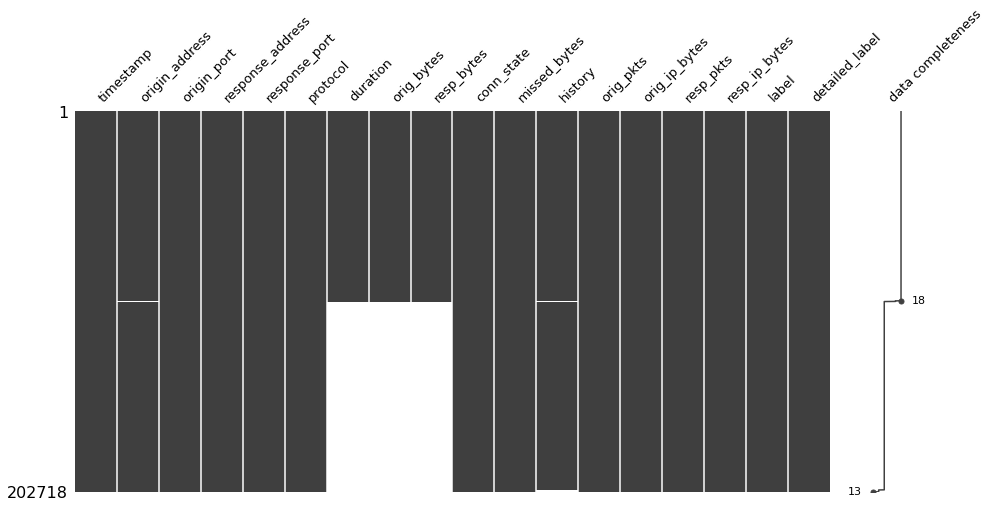

In [19]:
# Quick visualisation with msno
import missingno as msno

msno.matrix(data_df, labels=True, sort="descending", figsize=(15, 7), fontsize=13)
plt.show()

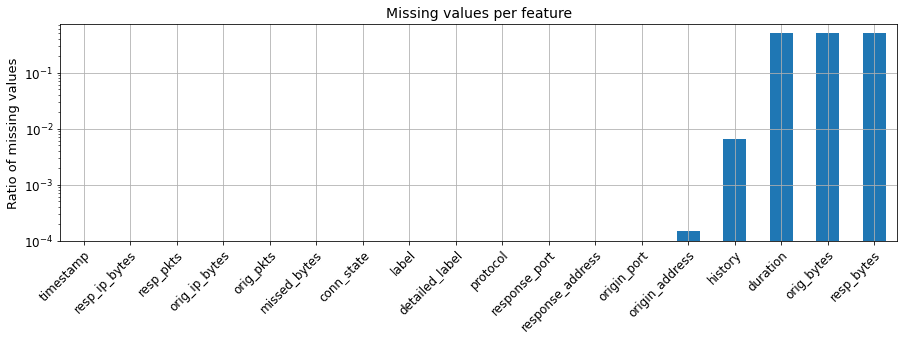

In [20]:
# Plot missing values per feature
data_df.isna().mean().sort_values().plot.bar(figsize=(15, 4), grid=True, fontsize=12)
plt.title('Missing values per feature',fontsize=14)
plt.ylabel('Ratio of missing values', fontsize=13)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.yscale('log')
plt.show()

> From the combination of the above two plots we can see that:
> - the missing values for the features **duration**, **orig_bytes** and **resp_bytes** come from the same entries and are ~50%. 
> - the features **history** and **origin_adress** have <0.5% of missing values.

> The replacement of the missing entries in those features will be addressed after checking the content of data.

---
#### **2.2 Check for spurious entries**
---

---
##### **2.2.1 Numerical**
---

> For the numerical features, we have already seen from the descriptive statistics that the bytes (or ip bytes) and the number of packets have rather small values up to the 75th percantile while the max values were quite large. To identify those entries we can plot the values of each feature as a function of the number of entries. 

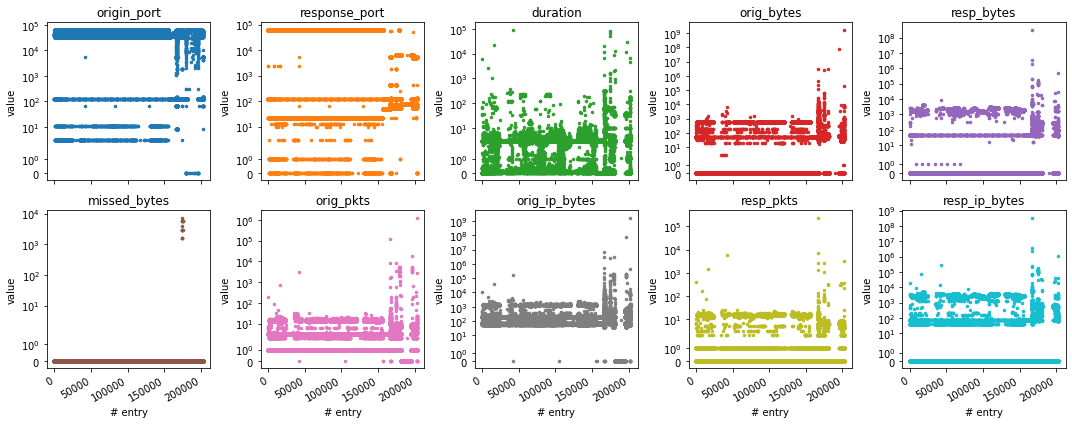

In [21]:
# Plot values per numerical feature
df_num = data_df.select_dtypes(include='number')

df_num.plot(lw=0, marker=".", subplots=True, layout=(-1, 5), figsize=(15, 6), markersize=5, 
            logy='sym', xlabel='# entry', ylabel='value', title=df_num.columns.to_list(), legend=False)

plt.tight_layout()
plt.show()

> From the above plot we can identify two distinct periods of traffic:
> - in the first ~150,000 entries, there is wide range of the same origin_ports and a smaller number of response_ports used, but they are almost the same for all those entries. These entries should correspond to the detailed label "PartOfAHorizontalScan" as their total number match. There are roughly 10-1000 bytes, without missing any, send from both the originator and the responder resulting in few packets, below ~30. 
> - in the last ~50,000 entries, is where large fluctuations on the number of bytes, packets or missed bytes appear as well as their maximum values which seem to correspond only to few entries. For these entries, it seems that there is also a port scan in almost the same origin ports as for the first 150,000 entries but most of the response ports differ.

> We can check how many entries have missing bytes and how many entries have the very large values in duration and bytes. 

---
##### **Check the type of traffic, protocol and connection state for the entries with missing bytes**

---

In [22]:
missed_bytes = data_df.loc[data_df['missed_bytes']>1][['detailed_label', 'protocol', 'conn_state']].value_counts()
print('-'*50,'\n Missing bytes:\n','-'*50)
print(missed_bytes,'\n','-'*50)
print('Total number of entries:', missed_bytes.sum(),'\n','-'*50)

-------------------------------------------------- 
 Missing bytes:
 --------------------------------------------------
detailed_label  protocol  conn_state
Benign          tcp       SF            18
dtype: int64 
 --------------------------------------------------
Total number of entries: 18 
 --------------------------------------------------


> There are in total 18 entries where there are missing bytes coming from benign entries through the tcp protocol and with a connection state SF which stands for "Normal establishment and termination".

---
##### **Check the type of traffic, protocol and connection state for the entries with large values in origin bytes, ip_bytes and packets**

---

In [23]:
large_vals = data_df.loc[(data_df['duration']>500) | 
                         (data_df['orig_bytes']>=1e5) | 
                         (data_df['orig_ip_bytes']>=1e4) | 
                         (data_df['resp_ip_bytes']>=1e4)][['detailed_label', 'protocol', 'conn_state']].value_counts()

print('-'*55,'\n Large values in bytes and packets:\n','-'*55)
print(large_vals,'\n','-'*55)
print('Total number of entries:', large_vals.sum(),'\n','-'*55)

------------------------------------------------------- 
 Large values in bytes and packets:
 -------------------------------------------------------
detailed_label             protocol  conn_state
Benign                     tcp       SF            20
DDoS                       tcp       S0            10
PartOfAHorizontalPortScan  tcp       S0            10
Benign                     tcp       RSTR          10
                           udp       S0             9
                           tcp       S0             8
C&C                        tcp       S1             7
Benign                     tcp       S3             6
                                     OTH            4
C&C                        tcp       S3             3
                                     RSTR           3
DDoS                       udp       S0             2
Benign                     tcp       S1             2
                                     RSTO           1
PartOfAHorizontalPortScan  udp       S0       

> There are in total 98 entries where the large values appear in the bytes and duration coming from all the different classes with mostly problems in the connection state. 

---
##### **Check if the entries where the bytes are missing are the same as those where the large values appear**

---

In [24]:
# Define list of indices
idx1 = data_df.loc[data_df['missed_bytes']>1].index
idx2 = data_df.loc[(data_df['duration']>500) | 
                   (data_df['orig_bytes']>=1e5) | 
                   (data_df['orig_ip_bytes']>=1e4) | 
                   (data_df['resp_ip_bytes']>=1e4)].index

# Compare indices
idx1.isin(idx2)

array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

> There are 7 additional entries where bytes are missing and are not in common with the entries where there are large values in the number of bytes or packets. We can try to check after removing those 105 entries how the values per feature and boxplots look like. 

---
##### **Plot again the values per feature after removing those spurious entries**

---

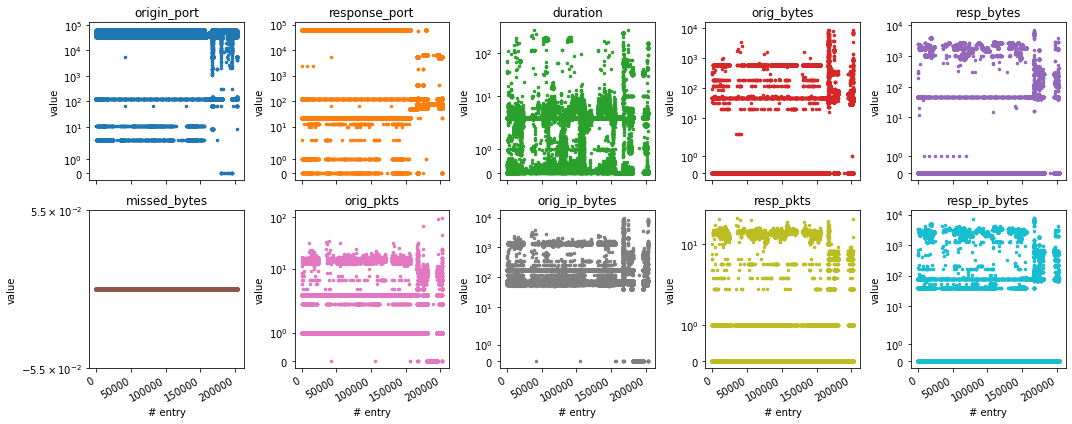

In [25]:
# Get the mask
mask = data_df.loc[(data_df['duration']>500) | 
                   (data_df['orig_bytes']>=1e5) | 
                   (data_df['orig_ip_bytes']>=1e4) | 
                   (data_df['resp_ip_bytes']>=1e4) |
                   (data_df['missed_bytes']>1)].index

# Get numeric data into a new dataframe, drop the rows and reset index
df_num = data_df.select_dtypes(include='number')
df_num = df_num.drop(df_num.index[[mask]], axis=0)
df_num = df_num.reset_index(drop=True)

# Plot again the values per numerical features
df_num.plot(lw=0, marker=".", subplots=True, layout=(-1, 5), figsize=(15, 6), markersize=5, 
            logy='sym', xlabel='# entry', ylabel='value', title=df_num.columns.to_list(), legend=False)

plt.tight_layout()
plt.show()

---
##### **Check again boxplots**

---

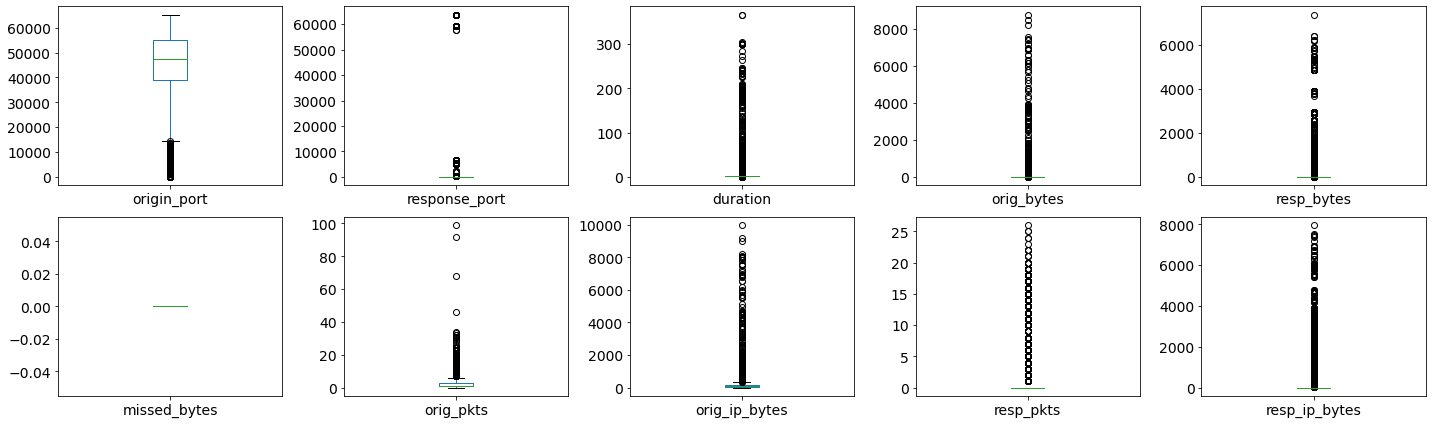

In [26]:
df_num.plot.box(subplots=True, layout=(-1, 5), figsize=(20, 6), fontsize=14)
plt.tight_layout()
plt.show()

> By dropping those additional 105 entries the "outliers" have been vanished and the boxplots are more clear. The missed_bytes feature since it contains now only 0 values can be droppped. 

> We can proceed by defining this additional preprocessing step. 

In [27]:
# Drop spurious entries and missed_bytes feature
def preprocess_step5(input_df):
    
    # Get a copy of the dataframe
    df = input_df.copy()
    
    # Get the mask
    mask = df.loc[(df['duration']>500) | 
                  (df['orig_bytes']>=1e5) | 
                  (df['orig_ip_bytes']>=1e4) | 
                  (df['resp_ip_bytes']>=1e4) |
                  (df['missed_bytes']>1)].index

    df = df.drop(df.index[[mask]], axis=0)
    df = df.reset_index(drop=True)    
    
    # Drop column
    df = df.drop(['missed_bytes'], axis=1)
    
    return df

In [28]:
# Process dataframe
data_df = preprocess_step5(data_df)

# Get number of entries after dropping spurious entries
entries_reduced2 = data_df.shape[0]
print('Number of entries from spurious entries:',entries_reduced-entries_reduced2)
print('Number of entries after dropping spurious entries:', entries_reduced2)

Number of entries from spurious entries: 105
Number of entries after dropping spurious entries: 202613


---
#### **2.2.2 Categorical**
---

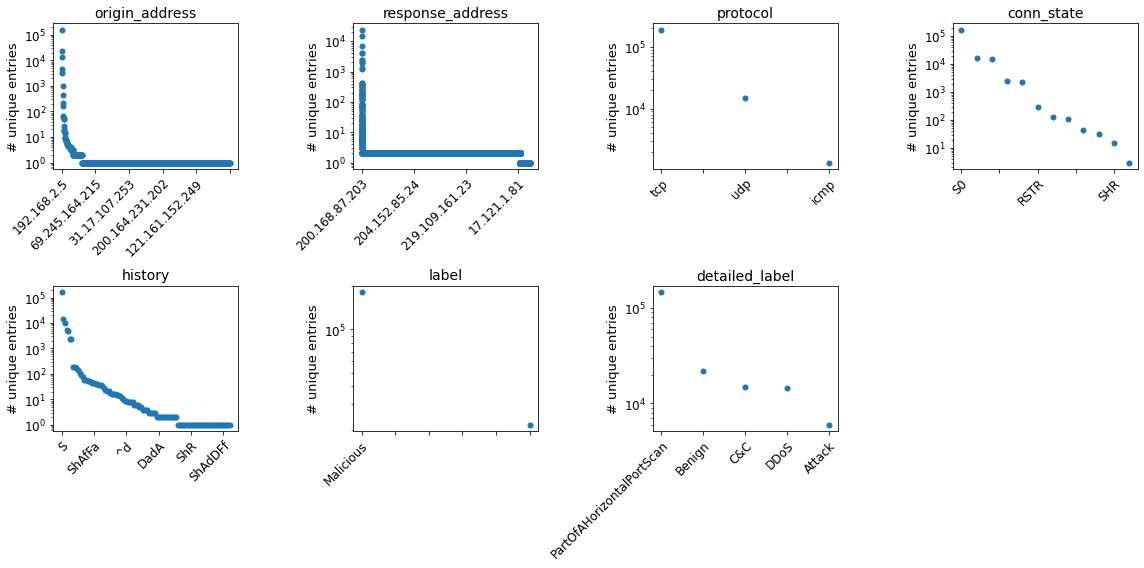

In [29]:
# Plot number of occurence per unique value per feature
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))

# Dataframe with only categorical features
df_cat = data_df.select_dtypes(include='object').copy()

for col, ax in zip(df_cat.columns, axes.ravel()):
    df_cat[col].value_counts().plot(lw=0, marker="o", markersize=5, logy=True, fontsize=12, ax=ax)
    ax.set_ylabel('# unique entries', fontsize=13)
    ax.set_title(col, fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right', rotation_mode='anchor')

axes.flat[-1].set_visible(False)# Don't saw last empty plot    
plt.tight_layout()
plt.show()

> From the above plots we see see that:
> - there are about 10 origin addresses and a bit more response addresses with more than 100 entries each. The top addresses with most entries are the 192.168.2.5 (1.5e5 entries) and the 200.168.87.203 (~2.5e4 entries) respectively as we have already seen from the descriptive statistics.  However, from the total number of those addresses most of them have a couple of entries. 
> - most of the traffic was performed through the TCP protocol (1e5 entries), about 1.5e4 comes from UDP connections while the ICMP protocol has few entries. 
> - the top connection state S0 has about the same number of entries as the top origin address. There are 2 connection states with about 2e4 entries each, 2 with ~2e3 entries each and the rest have unique entries less than ~200. 
> - the top history S has about the same number of entries as the top origin address. Most of the history labels are used more than a couple of times and some of them have ~1e4 unique entries. 
> - the detailed label 'PartOfAHorizontalScan' has about the same number of entries as the top origin address. 

<div class="alert alert-block alert-success">
<b>Summary from the quality inverstigation</b> 
<hr>
    
<u>Missing values:</u>     
    The features <b>origin_bytes, response_bytes and duration</b> have the same amount of missing values for the same entries, while the missing entries in the <b>history</b> and <b>origin_address</b> have only few. For these features the investigation for their replacement will be done later. 
    
<u>Spurious entries:</u>  
- There are only 18 entries where there are missing bytes corresponding to benign entries without problems in the connection. 
- There are 98 entries where the outlies in the bytes and duration appear corresponding to all different classes with mostly problems in the connection states. 
- The above entries which are in total 105 (as there are 7 entries not in common between spurious entries and missed bytes) can be dropped.
- The feature <b>missed_bytes</b> can be also dropped since after dropping the spurious entries it contains only 0 values.
    
   
<u>To be checked:</u>     
- Further investigation is needed for the PartOfAHorizontalScanPort entries.
</div>

---
### **3. Content of data**
---

---
#### **3.1. Categorical features**
---

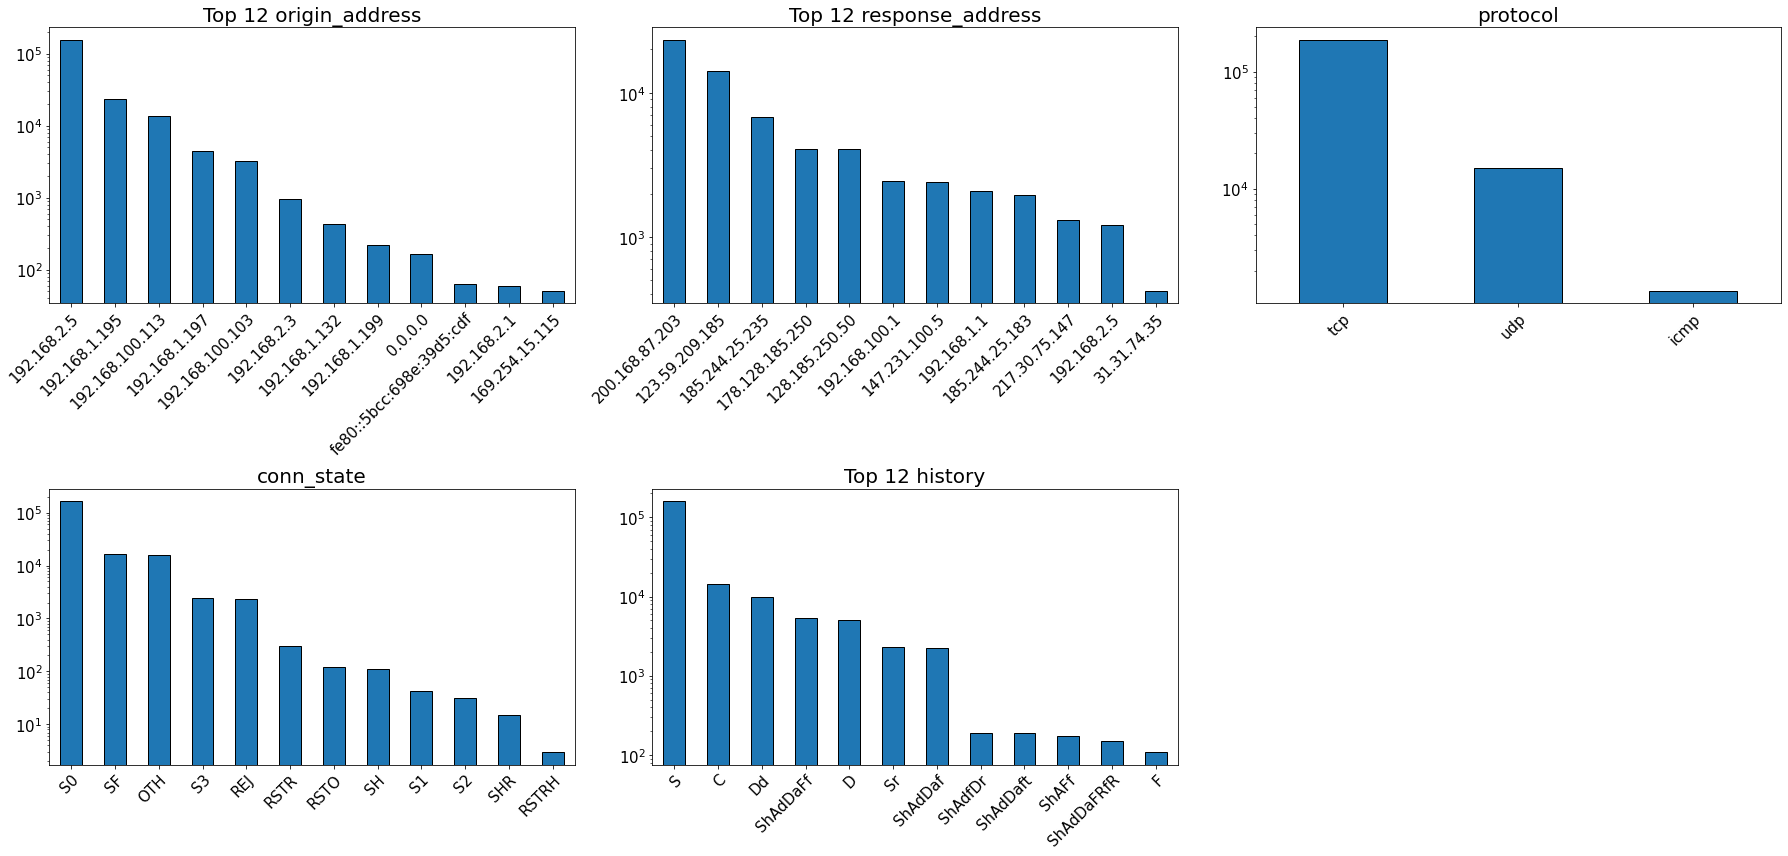

In [30]:
# Plot top 12  
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(25, 12))

# Select categorical features
df_categorical = data_df.select_dtypes(include=['object']).drop(['label', 'detailed_label'], axis=1)

# Loop through features and put each subplot on an axis object
for col, ax in zip(df_categorical.columns, axes.ravel()):
    # For each categorical feature, count the number of occurrences per unique value and plot top 12
    df_categorical[col].value_counts().head(12).plot(kind='bar', edgecolor='black', logy=True, ax=ax, fontsize=15)
    if ((col=='protocol') | (col=='conn_state')):
        ax.set_title(col, fontsize=20)
    else:
        ax.set_title('Top 12 '+col, fontsize=20)
 
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right', rotation_mode='anchor')

axes.flat[-1].set_visible(False)# Don't saw last empty plot    
plt.tight_layout()
plt.show()

> In addition to a similar plot that we saw in the previous section, on this one we can see that:
> - The top 8 **origin_addresses** (the IP address where the attack happened) are mainly non-routable IP addresses in the range 192.168.x.x. The address 0.0.0.0 is a non-routable meta-address used to designate an invalid, unknown or non-applicable target (https://en.wikipedia.org/wiki/0.0.0.0) 
> - The top 12 **response_addresses** (the IP address where the capture happened) are quite variable in the context of their IP range
> - The connection state S0 (Connection attempt seen, no reply) and the history S send from the originator (a SYN w/o the ACK bit set) are the top one with more than 1e5 entries.

> We can check each feature one by one and with respect to the labels and the detailed labels.

---
##### **3.1.1 Origin address**

---

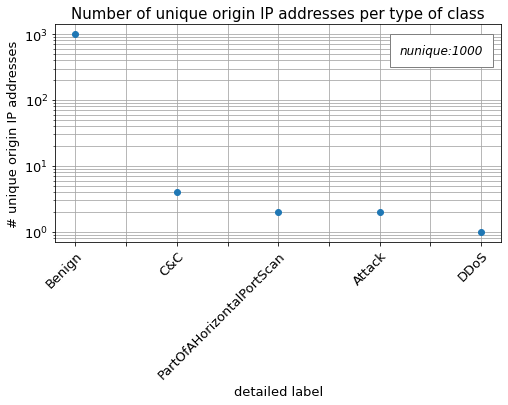

In [31]:
# Number of unique connection states per type of class
plt.figure(figsize=(8, 4))
data_df.groupby('detailed_label')['origin_address'].nunique().sort_values(ascending=False).plot(lw=0, marker='o', fontsize=13)
plt.xlabel('detailed label', fontsize=13)
plt.ylabel('# unique origin IP addresses', fontsize=13)
plt.title('Number of unique origin IP addresses per type of class', fontsize=15)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
text_box='nunique:{:.0f}'.format(data_df['origin_address'].nunique())
plt.text(3.2, 500, text_box, style='italic', fontsize=12,
        bbox={'facecolor': 'white', 'edgecolor':'grey', 'pad': 10})
plt.yscale('log')
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

> The unique origin IP addresses per type of class are as following: 
> - **Benign**: 1000  (all unique addresses)
> - **C&C**: 4 
> - **PartOfAHorizontalPortScan**: 2 
> - **Attack**: 2 
> - **DDoS**: 1

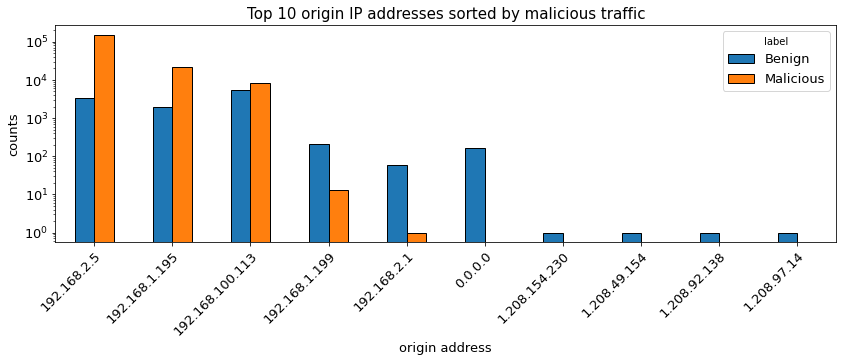

In [32]:
# Top 10 origin IP addresses sorted by malicious traffic
df = data_df.groupby('origin_address')['label'].value_counts()
df.unstack(level=-1).sort_values(by='Malicious', ascending=False).head(10).plot(kind='bar', edgecolor='black', figsize=(14, 4), fontsize=13)
plt.title('Top 10 origin IP addresses sorted by malicious traffic', fontsize=15)
plt.xlabel('origin address', fontsize=13)
plt.ylabel('counts', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=13, title='label')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.show()

> For malicious traffic there are only 5 unique origin IP addresses that are used: 
> - the **192.168.2.5** with ~1e5 entries
> - the **192.168.1.195** with ~2e4 entries
> - the **192.168.100.113** with ~1e4 entries
> - the **192.168.1.199** with ~20 entries
> - the **192.168.2.1** with only 1 entry

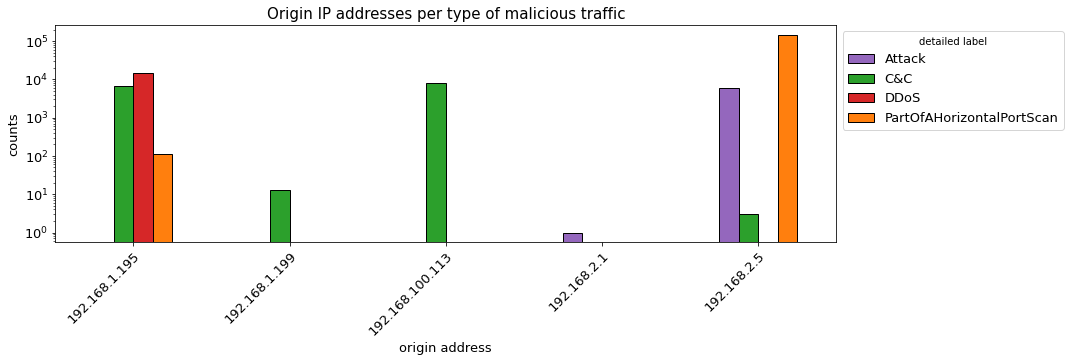

In [33]:
# Origin IP addresses per malicious class
df = data_df.loc[data_df['detailed_label']!='Benign'].groupby('origin_address')['detailed_label'].value_counts()
df.unstack(level=-1).plot(kind='bar', edgecolor='black', figsize=(14, 4), fontsize=13,
                          color=['tab:purple', 'tab:green', 'tab:red', 'tab:orange'])
plt.title('Origin IP addresses per type of malicious traffic', fontsize=15)
plt.xlabel('origin address', fontsize=13)
plt.ylabel('counts', fontsize=13)
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='detailed label', fontsize=13)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.show()

> **Summary table for origin IP addresses used in malicious traffic:**


>| detailed_label | 192.168.1.195 | 192.168.1.199 | 192.168.100.113 | 192.168.2.1 | 192.168.2.5|
>| --- | --- | --- | --- | --- | --- | 
>| **Attack** | - | - | - | 1 entry | ~1e4 entries |
>| **C&C** | ~6e3 entries | ~20 entries | ~1e4 entries | - | ~3 entries | 
>| **DDoS** | ~1e4 entries| - | - | - | - |
>| **PartOfAHorizontalScan** | ~1e4 entries | - | - | - | ~1e5 entries |


---
##### **3.1.2 Response address**

---

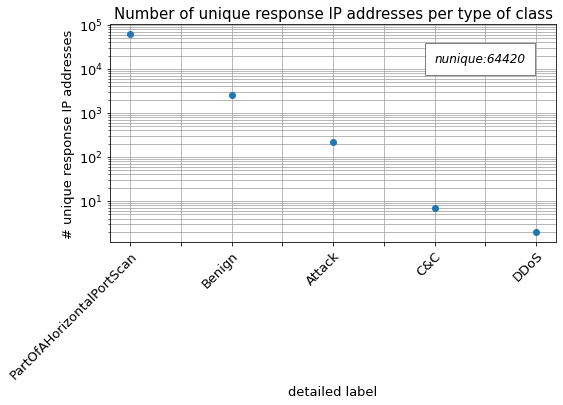

In [34]:
# Number of unique connection states per type of class
plt.figure(figsize=(8, 4))
data_df.groupby('detailed_label')['response_address'].nunique().sort_values(ascending=False).plot(lw=0, marker='o', fontsize=13)
plt.title('Number of unique response IP addresses per type of class', fontsize=15)
plt.xlabel('detailed label', fontsize=13)
plt.ylabel('# unique response IP addresses', fontsize=13)
plt.yscale('log')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')

text_box='nunique:{:.0f}'.format(data_df['response_address'].nunique())
plt.text(3, 14000, text_box, style='italic', fontsize=12,
        bbox={'facecolor': 'white', 'edgecolor':'grey', 'pad': 10})

plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

> The unique response IP addresses per type of class are as following: 
> - **PartOfAHorizontalPortScan**: 64420  (all unique addresses)
> - **Benign**: ~2500
> - **Attack**: ~200 
> - **C&C**: 7 
> - **DDoS**: 2

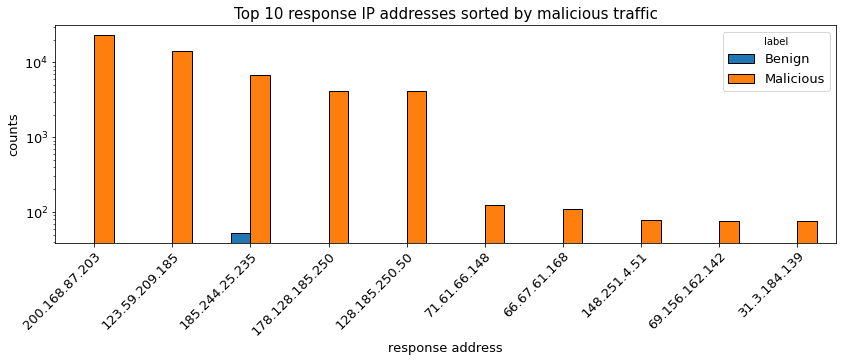

In [35]:
# Top 10 response IP addresses sorted by malicious traffic
df = data_df.groupby('response_address')['label'].value_counts()
df.unstack(level=-1).sort_values(by='Malicious', ascending=False).head(10).plot(kind='bar', edgecolor='black', figsize=(14, 4), fontsize=13)
plt.title('Top 10 response IP addresses sorted by malicious traffic', fontsize=15)
plt.xlabel('response address', fontsize=13)
plt.ylabel('counts', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=13, title='label')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.show()

> The top 5 response IP addresses have more more 4e3 entries each while the rest have less than 200 entries.

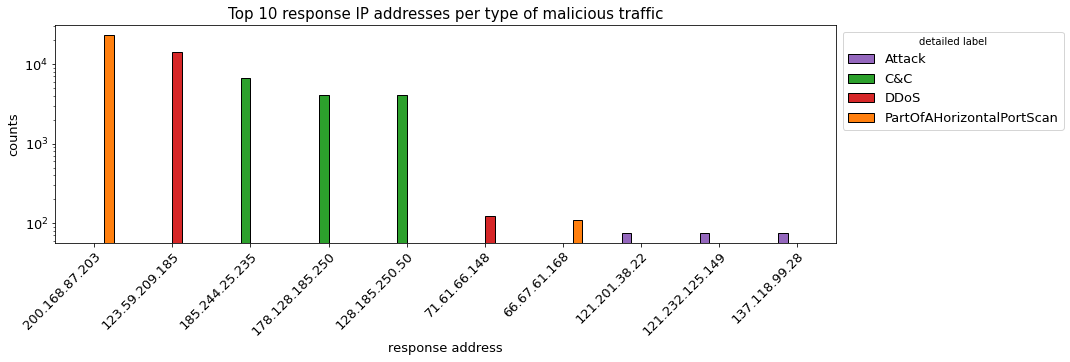

In [36]:
#Number of entries of origin IP addresses per type of malicious traffic
df = data_df.loc[data_df['detailed_label']!='Benign'].groupby('response_address')['detailed_label'].value_counts().nlargest(10)
df.unstack(level=-1).plot(kind='bar', edgecolor='black', figsize=(14, 4), fontsize=13,
                          color=['tab:purple', 'tab:green', 'tab:red', 'tab:orange'])
plt.title('Top 10 response IP addresses per type of malicious traffic', fontsize=15)
plt.xlabel('response address', fontsize=13)
plt.ylabel('counts', fontsize=13)
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='detailed label', fontsize=13)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.show()

> The top 5 response addresses with more than 3e4 entries are used in a port scan, DDoS and C&C while the rest have less than 100 entries each.

---
##### **3.1.3 Protocol**

---

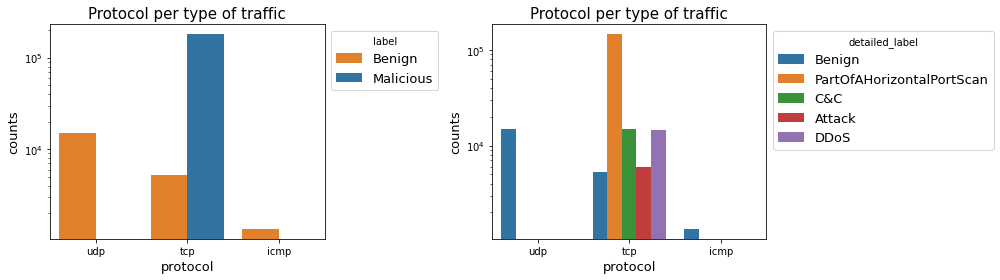

In [37]:
import warnings
warnings.filterwarnings("ignore")

# Protocol per type of traffic
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(x=data_df['protocol'], hue = data_df['label'], ax=ax[0],
             palette=['tab:orange', 'tab:blue'])
ax[0].set_title('Protocol per type of traffic', fontsize=15)
ax[0].set_xlabel('protocol', fontsize=13)
ax[0].set_ylabel('counts', fontsize=13)
ax[0].set_yscale('log')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), title='label', fontsize=13)

# Protocol per type of malicious traffic
sns.countplot(x=data_df['protocol'], hue = data_df['detailed_label'], ax=ax[1], 
              palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
ax[1].set_title('Protocol per type of traffic', fontsize=15)
ax[1].set_xlabel('protocol', fontsize=13)
ax[1].set_ylabel('counts', fontsize=13)
ax[1].set_yscale('log')
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), title='detailed_label', fontsize=13)

plt.tight_layout()        
plt.show()
           

> - **Benign** traffic is performed through all the 3 protocols: **TCP**, **UDP** and **ICMP**
> - **Malicious** traffic is performed only through the **TCP** protocol. 

---
##### **3.1.4 Connection state**

---

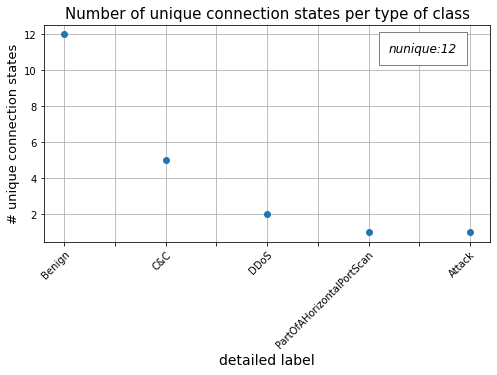

In [38]:
# Number of unique connection states per type of class
plt.figure(figsize=(8, 4))
data_df.groupby('detailed_label')['conn_state'].nunique().sort_values(ascending=False).plot(lw=0, marker='o')
plt.title('Number of unique connection states per type of class', fontsize=15)
plt.xlabel('detailed label', fontsize=14)
plt.ylabel('# unique connection states', fontsize=13)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
text_box='nunique:{:.0f}'.format(data_df['conn_state'].nunique())
plt.text(3.2, 11, text_box, style='italic', fontsize=12,
        bbox={'facecolor': 'white', 'edgecolor':'grey', 'pad': 10})
plt.grid()
plt.show()

> The unique connections states per type of class are as following: 
> - **Benign**: 12 (all unique connection states)
> - **C&C**: 5 
> - **DDoS**: 2
> - **PartOfAHorizontalPortScan**: 1  
> - **Attack**: 1

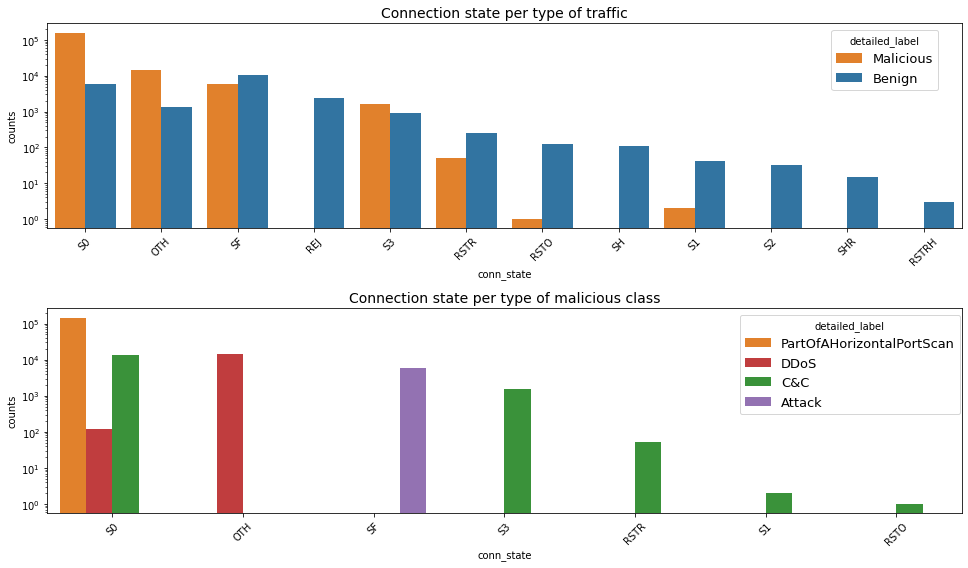

In [39]:
df1 = data_df.groupby('conn_state')['label'].value_counts().sort_values(ascending=False).to_frame(name='counts').reset_index()
df2 = data_df.loc[data_df['detailed_label']!='Benign'].groupby('conn_state')['detailed_label'].value_counts().sort_values(ascending=False).to_frame(name='counts').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# Connection state per type of traffic
sns.barplot(x='conn_state', y ='counts', hue = 'label', data=df1, ax=ax[0], palette=['tab:orange', 'tab:blue'])
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1), title='label')
ax[0].set_title('Connection state per type of traffic', fontsize=14)
ax[0].set_yscale('log')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45)
ax[0].legend(loc='upper left', bbox_to_anchor=(0.85, 1), title='detailed_label', fontsize=13)

# Connection state only for malicious entries
sns.barplot(x='conn_state', y ='counts', hue = 'detailed_label', data=df2, ax=ax[1], 
           palette=['tab:orange', 'tab:red', 'tab:green', 'tab:purple'])
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1), title='detailed_label')
ax[1].set_title('Connection state per type of malicious class', fontsize=14)
ax[1].set_yscale('log')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45)
ax[1].legend(loc='upper left', bbox_to_anchor=(0.75, 1), title='detailed_label', fontsize=13)

plt.tight_layout()
plt.show()

> For the **Malicious** there are 7 types of connection states 
> - For the **PartofAHorizontalScan** there is only 1, the **S0** (connection attempt seen, no reply)
> - For the **DDoS** there are 2 different types of connections, the **S0** and the **OTH** 
> - For the **C&C** there are also 5 different types of connections (**S0, S3, RSTR, S1, RST0**)
> - For the **Attack** there is only 1, the **SF** (normal establishment and termination)

> So the **SF** connection is only used in **Benign** and **Attack** while for all the rest of the malicious traffic there is a problem in the connection status. 

---
##### **3.1.5 History**

---

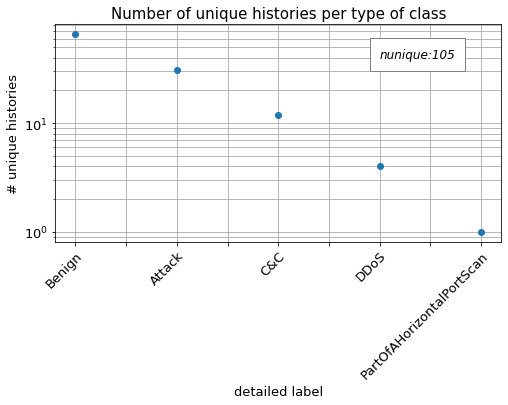

In [40]:
# Number of unique connection states per type of class
plt.figure(figsize=(8, 4))
data_df.groupby('detailed_label')['history'].nunique().sort_values(ascending=False).plot(lw=0, marker='o', fontsize=13)
plt.title('Number of unique histories per type of class', fontsize=15)
plt.xlabel('detailed label', fontsize=13)
plt.ylabel('# unique histories', fontsize=13)
plt.yscale('log')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')

text_box='nunique:{:.0f}'.format(data_df['history'].nunique())
plt.text(3, 40, text_box, style='italic', fontsize=12,
        bbox={'facecolor': 'white', 'edgecolor':'grey', 'pad': 10})

plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

> The unique histories (105 in total) per type of class are as following: 
> - **Benign**: ~65 
> - **Attack**: 30
> - **C&C**: ~11 
> - **DDoS**: 4
> - **PartOfAHorizontalPortScan**: 1  

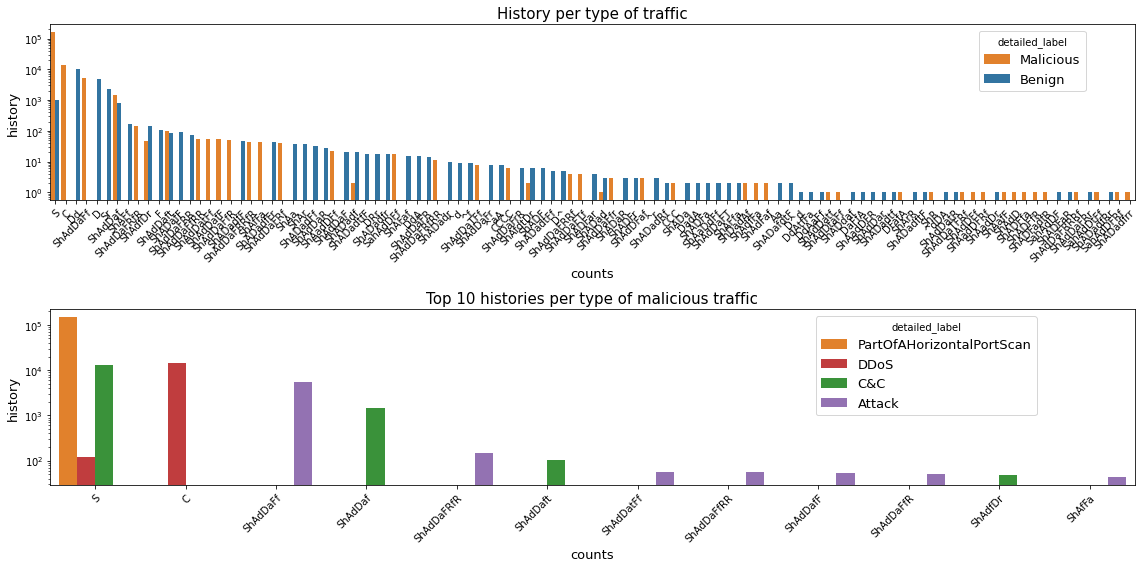

In [41]:
df1 = data_df.groupby('history')['label'].value_counts().sort_values(ascending=False).to_frame(name='counts').reset_index()
df2 = data_df.loc[data_df['detailed_label']!='Benign'].groupby('history')['detailed_label'].value_counts().sort_values(ascending=False).head(14).to_frame(name='counts').reset_index()

fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Plot top 
sns.barplot(x='history', y ='counts', hue = 'label', data=df1, ax=ax[0], palette=['tab:orange', 'tab:blue'])
ax[0].set_title('History per type of traffic', fontsize=15)
ax[0].set_xlabel('counts', fontsize=13)
ax[0].set_ylabel('history', fontsize=13)
ax[0].set_yscale('log')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45, ha='right', rotation_mode='anchor')
ax[0].legend(loc='upper left', bbox_to_anchor=(0.85, 1), title='detailed_label', fontsize=13)

# Plot top 10 addresses counts wrt detailed labels
sns.barplot(x='history', y ='counts', hue = 'detailed_label', data=df2, ax=ax[1],
           palette=['tab:orange', 'tab:red', 'tab:green', 'tab:purple'])
ax[1].set_title('Top 10 histories per type of malicious traffic', fontsize=15)
ax[1].set_xlabel('counts', fontsize=13)
ax[1].set_ylabel('history', fontsize=13)
ax[1].set_yscale('log')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90)
#ax[1].legend(loc='best')
ax[1].legend(loc='upper left', bbox_to_anchor=(0.7, 1), title='detailed_label', fontsize=13)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 45, ha='right', rotation_mode='anchor')

plt.tight_layout()
plt.show()

> The top connection state **S** is used by both benign and malicious traffic. For the latter it is used in the **PartOfAHorizontalPortScan**, **DDoS** and **C&C**.

---
#### **3.2. Numerical features**
---

> At first all the numerical features will be selected in a new dataframe and three different transformations (log, power and quantile) will be added, in order to look at their distributions and try to decide if some transformations will be useful. This is shown in the subsection 3.2.1 while in the subsections 3.2.2 - 3.2.5 each of the above 'category' of features (for e.g. untransformed, log transformed etc) is shown together with 3 different scalers in order to have an idea also how the scaled features look like as it is needed for some classifiers. 

In [42]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select numerical features
df_num = data_df.select_dtypes(include=['number'])
cols_num = df_num.columns.to_list()  

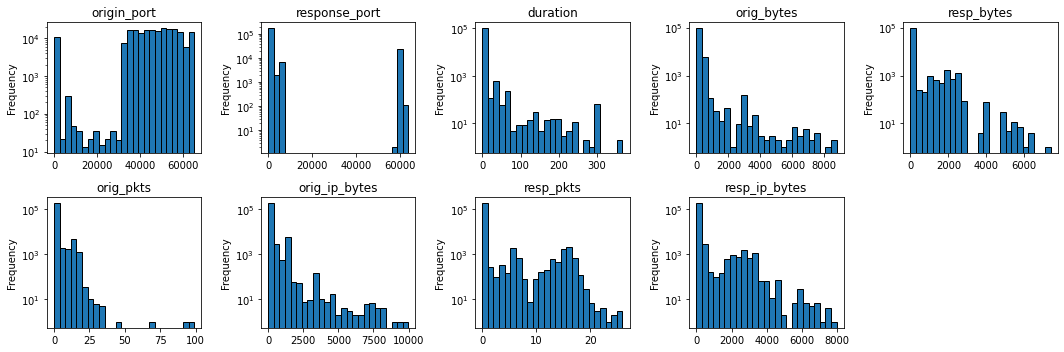

In [43]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 5))

for col, ax in zip(df_num.columns, axes.ravel()):
    df_num[col].plot.hist(bins=25, logy=True, edgecolor="black", ax=ax )
    ax.set_title(col)

axes.flat[-1].set_visible(False)# Don't saw last empty plot      
plt.tight_layout()
plt.show()

In [44]:
# Define transformations
pt = PowerTransformer(standardize=True)
qt = QuantileTransformer(output_distribution='normal', random_state=0, copy=False)

# Define the scalers
ss = StandardScaler()
mm = MinMaxScaler()

# Add transformations and scalers
for col in df_num.columns:
    # Scaled features 
    df_num[col + '_ss'] = ss.fit_transform(df_num[[col]])
    df_num[col + '_mm'] = mm.fit_transform(df_num[[col]])
    
    # Transformed features
    df_num[col + '_log'] = np.log1p(df_num[col])
    df_num[col + '_pt'] = pt.fit_transform(df_num[[col]])
    df_num[col + '_qt'] = qt.fit_transform(df_num[[col]])

---
##### **3.2.1 Distributions and tranformations**
---

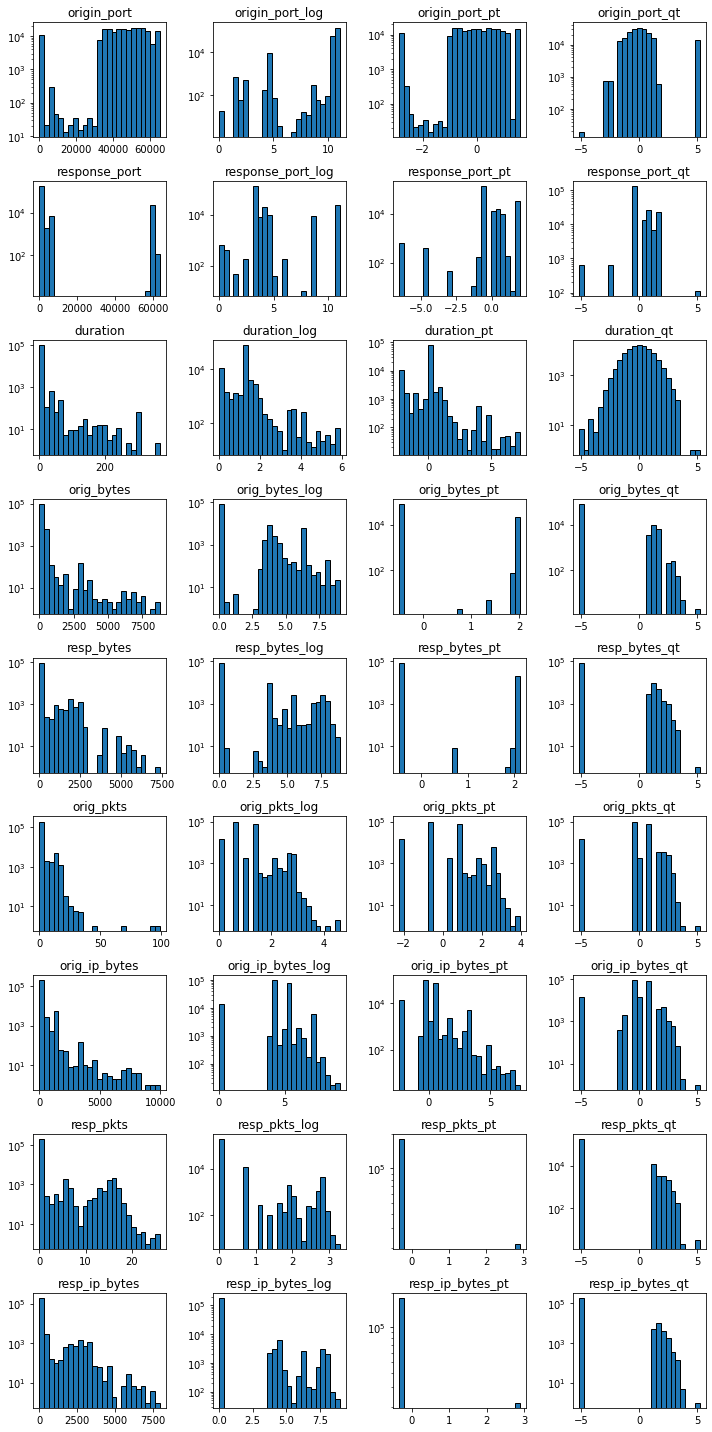

In [45]:
# Plot    
fig, ax = plt.subplots(nrows=len(cols_num), ncols=4, figsize=(10, 20))

for row in range(len(cols_num)):
    
    col = cols_num[row]
    
    ax[row,0].hist(df_num[col], bins=25, edgecolor="black")
    ax[row,0].set_title(col)
    ax[row,0].set_yscale('log')    
    
    ax[row,1].hist(df_num[col+'_log'], bins=25, edgecolor="black")
    ax[row,1].set_title(col+'_log')
    ax[row,1].set_yscale('log')   
    
    ax[row,2].hist(df_num[col+'_pt'], bins=25, edgecolor="black")
    ax[row,2].set_title(col+'_pt')
    ax[row,2].set_yscale('log')  
    
    ax[row,3].hist(df_num[col+'_qt'], bins=25, edgecolor="black")
    ax[row,3].set_title(col+'_qt')
    ax[row,3].set_yscale('log')   

plt.tight_layout()    
plt.show()

> After removing the outliers all the numerical features, except the port numbers, pick close to zero with ~1e5 entries and they are skewed towards their max values.
> For the port numbers, each bin in these histograms contain about 3,000 different numbers. 
> - for the origin ports with 30,000 unique values, most of the entries have low port numbers and in between ~30000 and ~60000
> - for the response ports with ~20 unique values, there are either low or very high port numbers used. 

> Concerning their transformations as we see none of them is perfect except the quantile transformation of the feature *duration* which is normal distributed.  

---
##### **3.2.2 Check scalers for untranformed features scaled**
---

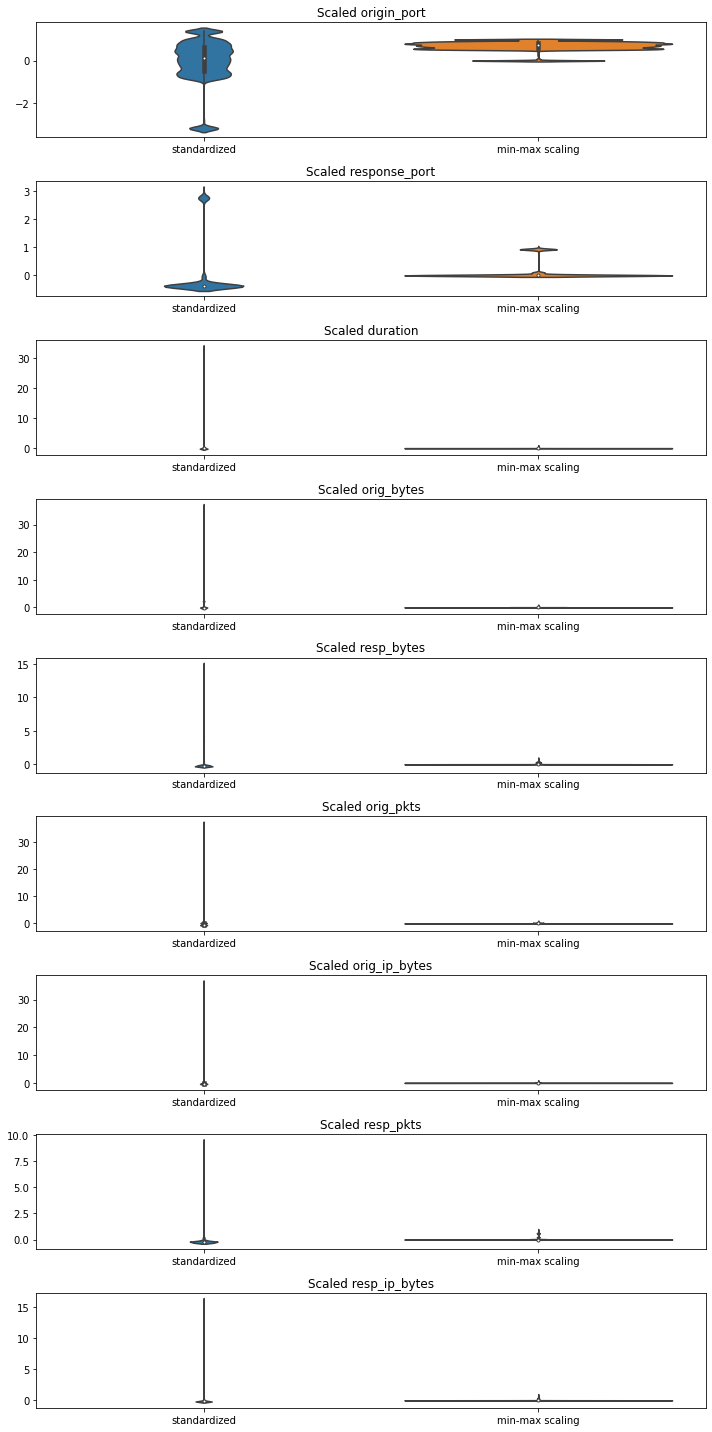

In [46]:
fig, ax = plt.subplots(nrows=len(cols_num), ncols=1, figsize=(10, 20))

for row in range(len(cols_num)):
    
    col = cols_num[row]
    
    df = df_num[[col+'_ss', col+'_mm']].copy()
    
    sns.violinplot(data=df, ax=ax[row])
    ax[row].set_xticklabels(labels=['standardized', 'min-max scaling'])
    ax[row].set_title('Scaled '+col)

plt.tight_layout()    
plt.show()    

> For the untransformed features with the standard scaler, we see that most of the datapoints are concentrated around 0 while the rest appear as outliers which is not actually the case as we have seen from the distributions above. For this reason, the **MinMaxScaler** which distributes all data points in between 0 and 1 seems more suitable if those features will be kept as they are in the final preprocessing steps. 

---
**3.2.3 Boxplots per type of class**

---

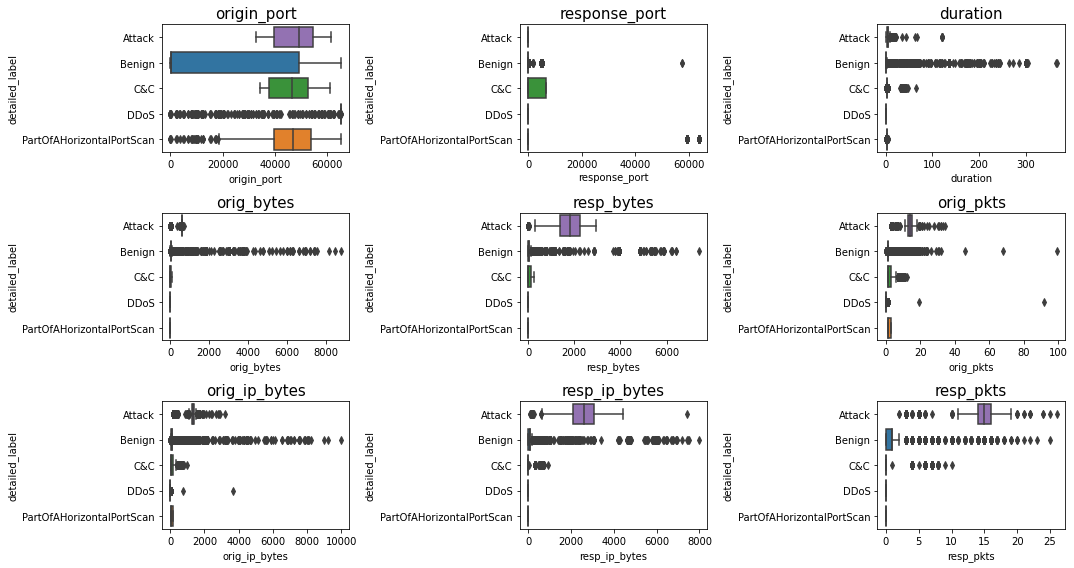

In [47]:
# Numeric features in order
cols_num = ['origin_port', 'response_port', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts',
                                                        'orig_ip_bytes', 'resp_ip_bytes', 'resp_pkts']

#Boxplots
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 8))

for col, ax in zip(cols_num, axes.ravel()):
    sns.boxplot(y = data_df['detailed_label'].astype('category'), x = col, data=data_df, ax=ax,
               palette=['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange'])
    ax.set_title(col, fontsize=15)

plt.tight_layout()
plt.show()

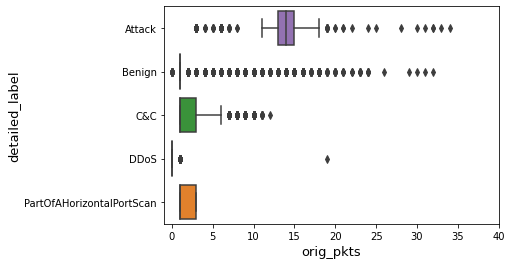

In [48]:
sns.boxplot(y = data_df['detailed_label'].astype('category'), x = 'orig_pkts', data=data_df, 
               palette=['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange'])
plt.xlim(-1,40)
plt.xlabel('orig_pkts', fontsize=13)
plt.ylabel('detailed_label', fontsize=13)
plt.show()

> - For the **origin_port**, we see that for the Attack, the C&C and the PartOfAHorizontalPortScan traffic the ports that are used in between the 1st and the 3rd quantile are in the range ~40,000-60,000 while the min values are about ~35,000 for the first two and 0 for the PartOfAHorizontalPortScan and the max values are ~60,000-65,000 for all. For the DDoS traffic the box (including Q1,median,Q3) and the max values are around ~65,000 while the min goes close to ~0. 
> - For the **response_port**, all different type of traffic except the C&C have their boxes, min and max values close to very low port numbers except the Benign and PartOfAHorizontalPortScan where the max values goes up to 60,000. For C&C the box, min and max values are in between 0 to ~5,000. 
> - The **duration** for the DDoS and PartOfAHorizontalPortScan traffic last few tens of seconds while C&C extends up to ~100s, Attack up to ~150s and Benign up to ~400s. 
> - The **origin_bytes** and **origin_ip_bytes** have the same statistics as expected for all type of traffic. The difference is that the ip_bytes are a bit higher in values as the ip header and footer are included in those packets when transmitted. In general, for the malicious traffic the bytes that are transmitted are a few kbs while for the benign traffic they go up to ~9-10kbs. The corresponding packets are in the range 0 to 100. 
> - The same stands for the **response_bytes** and **response_ip_bytes** but we see in general that those bytes have a max value lower than the bytes send from the originator and this is also visible in the packets that are transmitted which are in the range 0 to 25. For C&C, DDoS and PartOfAHorizontalPortScan the response bytes are a few while for the Attack they go go up to 3kbs and for benign up to <8kbs. 

---
**3.2.4 Values of each feature and histograms per type of class**

---

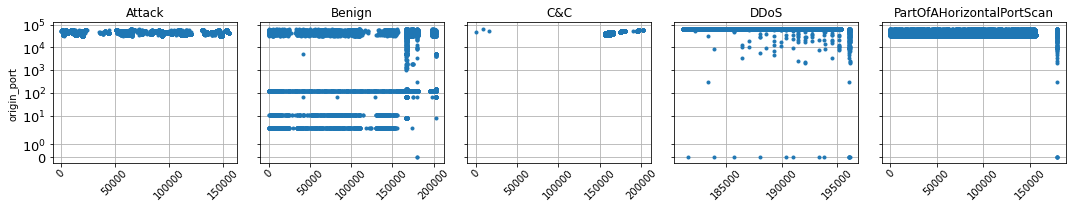

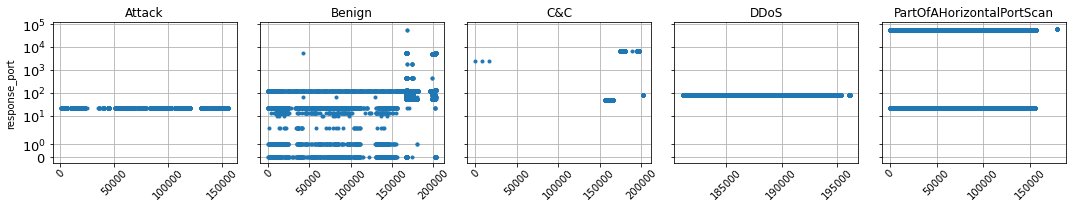

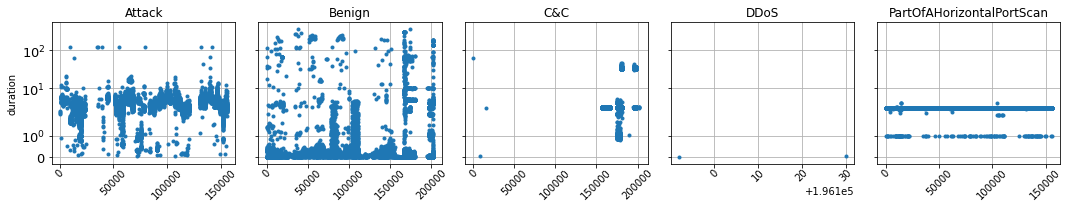

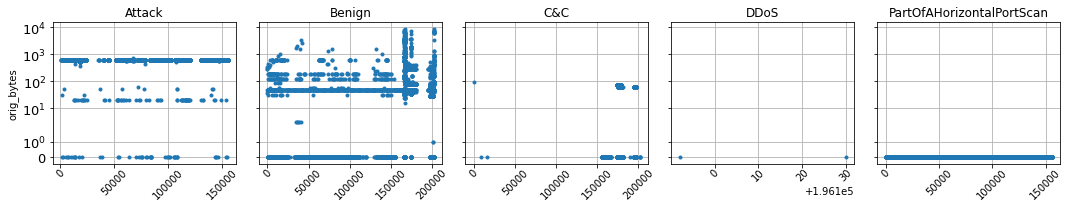

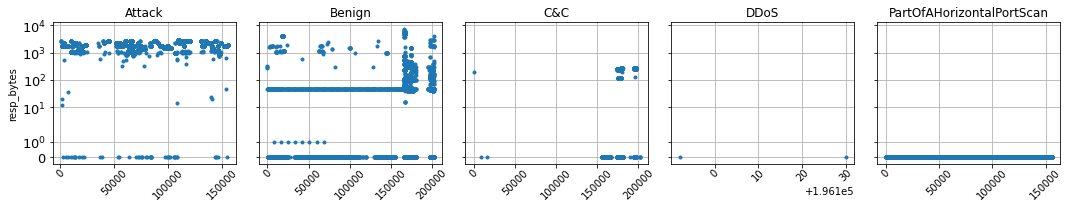

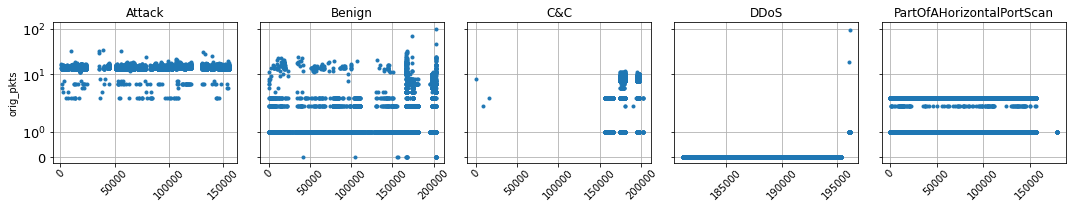

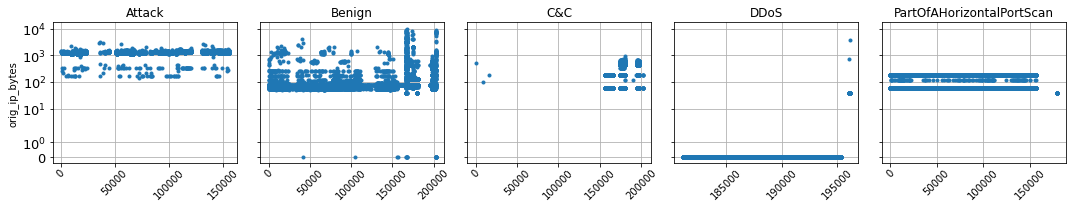

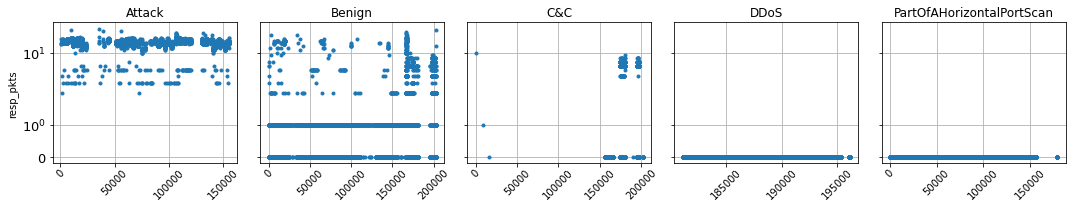

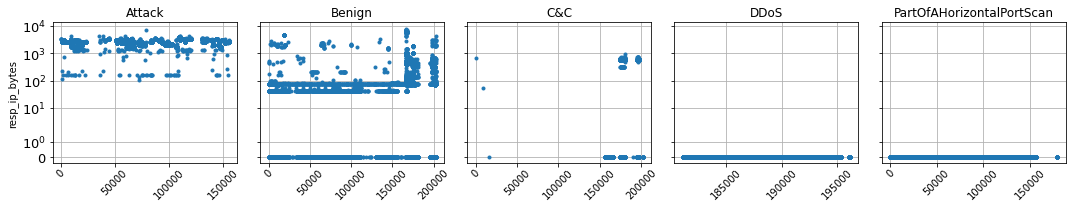

In [49]:
# Group dataframe wrt detailed labels
df_grouped = data_df.groupby('detailed_label')
df_num = data_df.select_dtypes(include='number')

for col in df_num.columns:
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True)

    for (key, ax) in zip(df_grouped.groups.keys(), axes.flatten()):
        df_grouped.get_group(key)[col].plot(ax=ax, lw=0, marker=".", title=key, legend=False, grid=True, ylabel=col, fontsize=13)
        ax.set_yscale('symlog')# to show also zero values
        ax.tick_params(axis='x', labelrotation = 45, labelsize=10, pad=0)

    plt.tight_layout()
    plt.show()

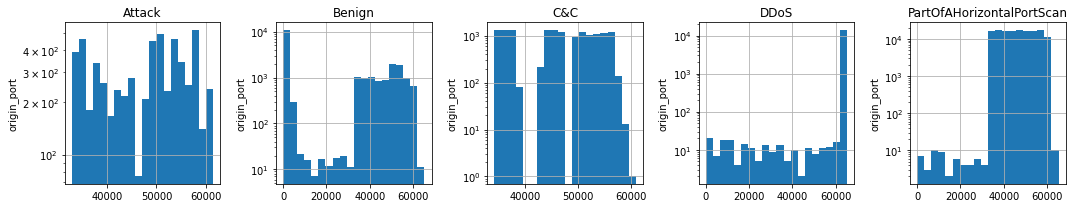

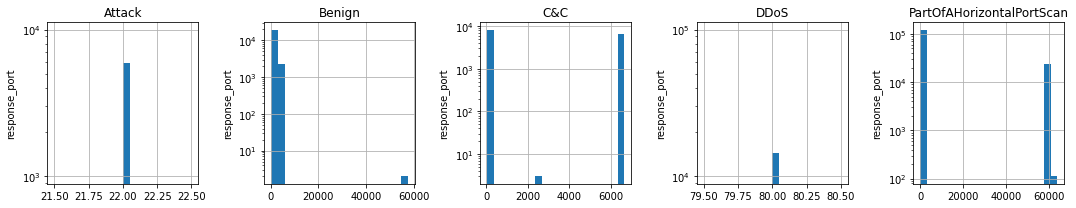

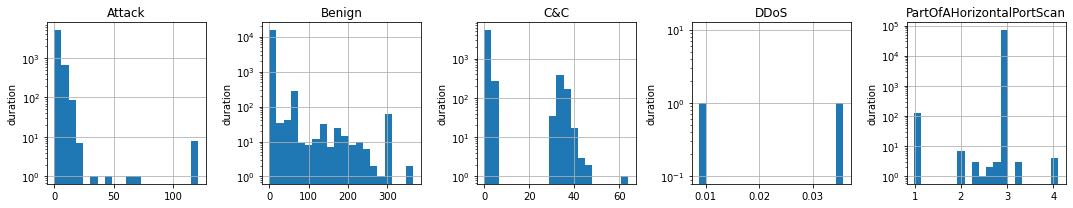

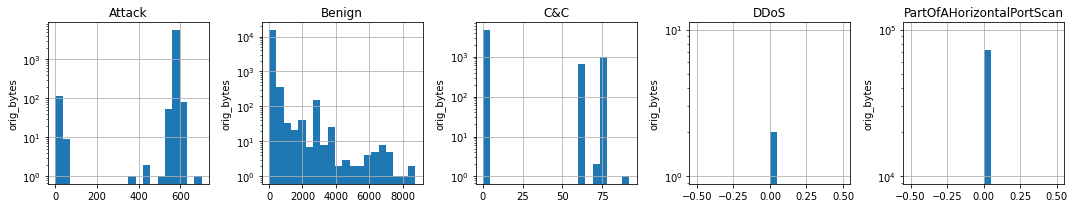

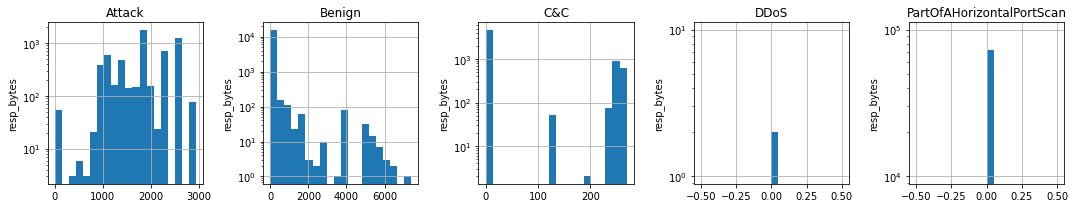

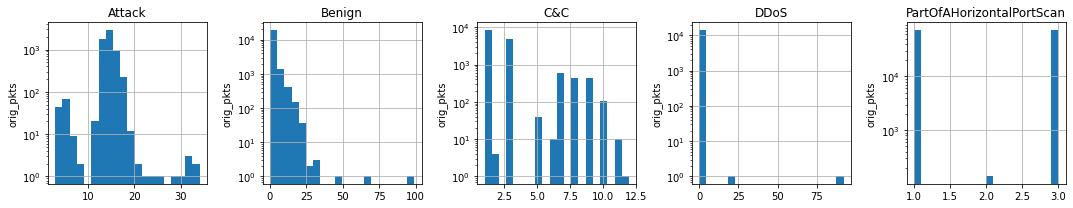

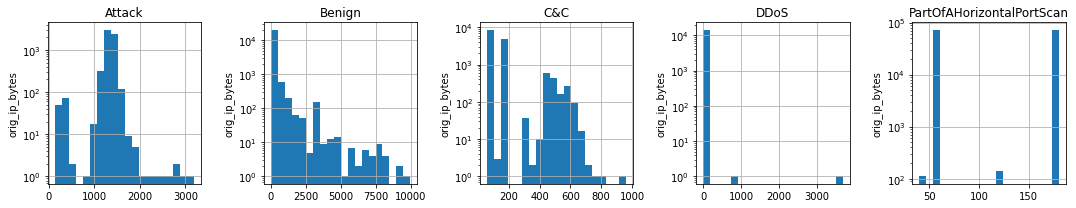

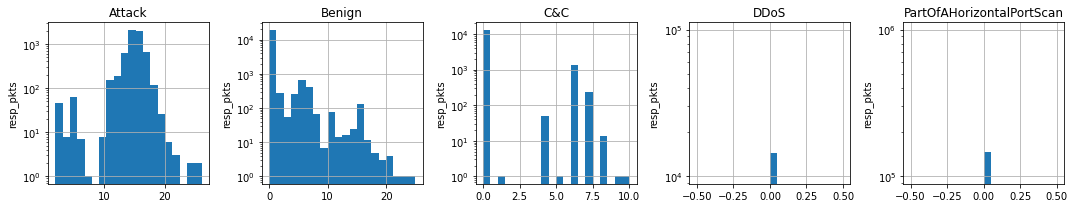

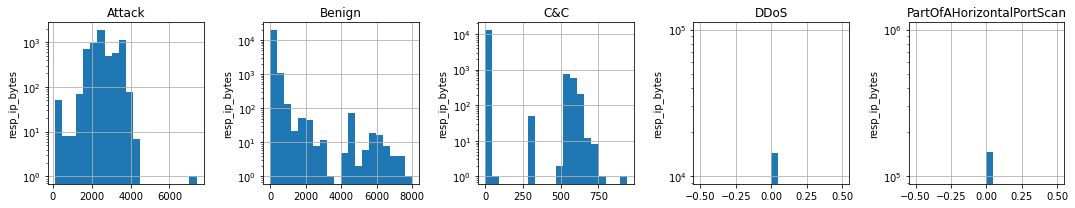

In [50]:
# Group dataframe wrt detailed labels
df_grouped = data_df.groupby('detailed_label')
df_num = data_df.select_dtypes(include='number')

for col in df_num.columns:
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3))

    for (key, ax) in zip(df_grouped.groups.keys(), axes.flatten()):
        df_grouped.get_group(key)[col].hist(ax=ax, bins=20)
        ax.set_title(key)
        ax.set_ylabel(col)
        ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

> From the above combination of plots we can derive the following summary table, which gives us the characteristics per type of traffic. We can see that each traffic and especially the malicious one, has very distinct characteristics wrt to the response ports which are used, as well as the duration and the bytes or packets send by the originator or the receiver. For this reason, additional features derived from those ones will not be explored. 

>| detailed_label | origin_port | response_port | duration | orig_bytes | resp_bytes |  orig_pkts | orig_ip_bytes | resp_pkts | resp_ip_bytes
>| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
>| Attack | 30,000-60,000 | 22 | 0-150s | 0-50, 300-600 | 0-30,000 | 1-35 | 0-3,000 | 1-30 | 0-4,000 |
>| Benign | 0-60,000 (mainly 0) | 0, 1, 5, ~10, ~100 | mainly 0 but vary up to 80,000s | mainly 0 | 0-6,500 | 0-30 | 0-10,000 | 0-30 | 0-8,000 | 
>| C&C | 30,000-60,000 | ~50, 100, ~6,000 | mainly 0-25,000s | mainly 0 | 0, ~120, 200-300 | 0-12 | 100-800 | 0-10 | 0-760 | 
>| DDoS | 0-65,000 (mainly ~65,000)| ~100, ~6,000 | 0 or 300 | mainly 0 | 0 | 0, 24, ~80 | 0 | 0 | 0 | 
>| PartOfAHorizontalScan | 0-60,000 (mainly 30,000-60,000) | 0 or ~60,000| 1-5 | mainly 0 | 0 | 1, 2, 3 | 60 or 80 | 0 | 0 | 



---
**3.2.5 Pairplots**

---

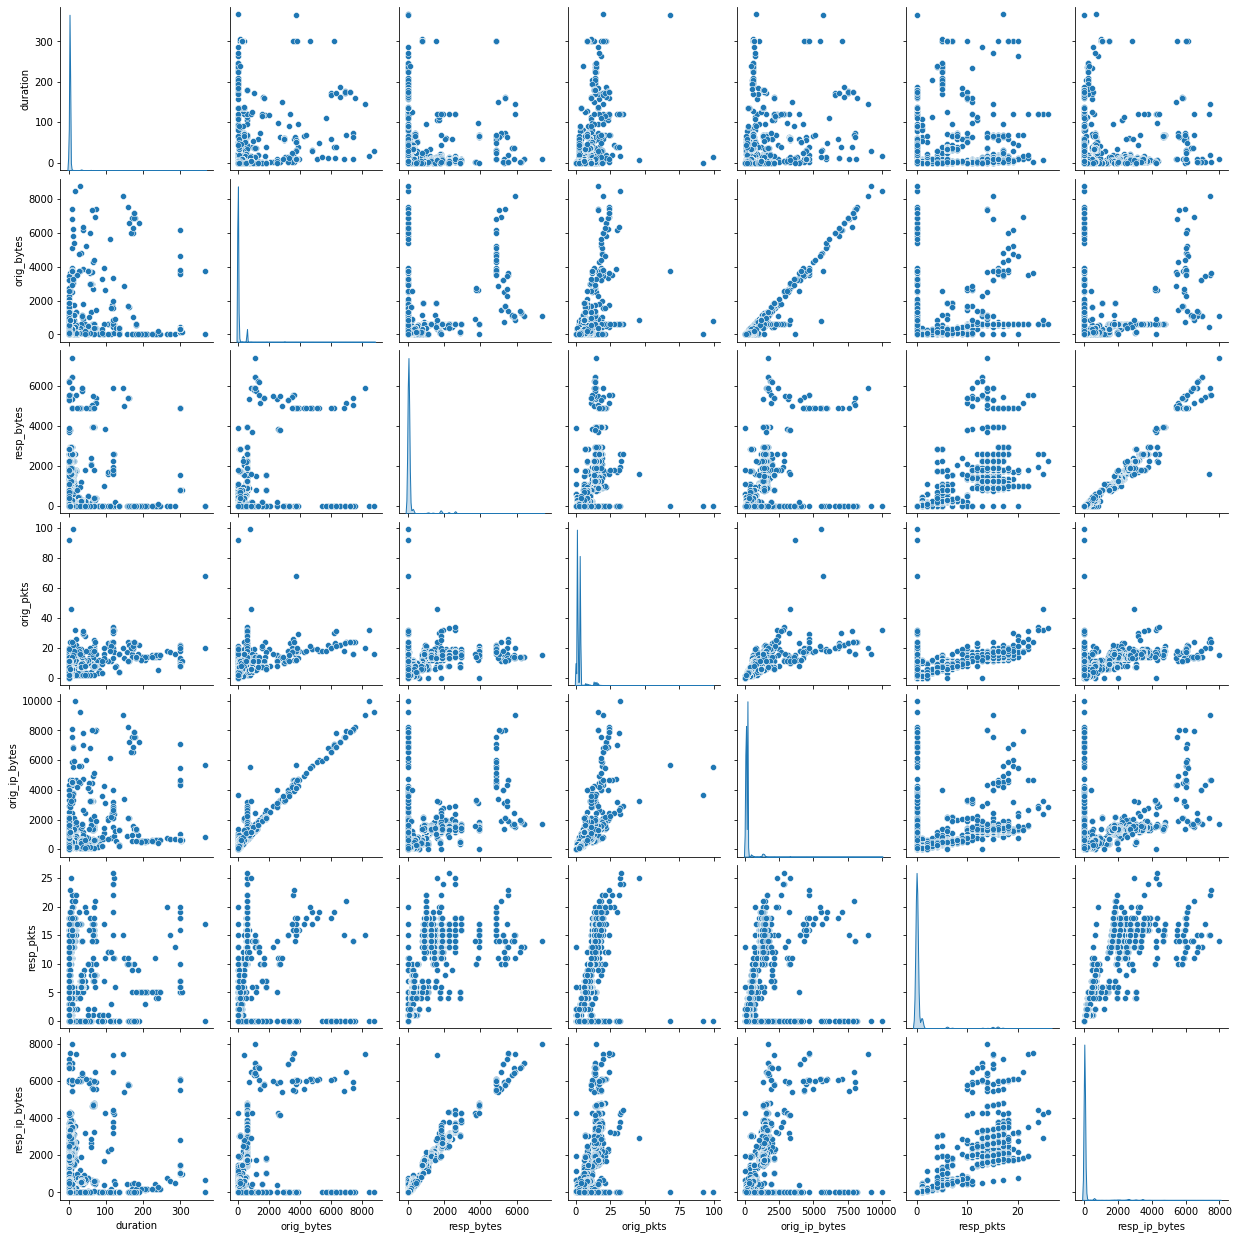

In [51]:
# Get the numerical features into a new dataframe
df_num = data_df.select_dtypes(include='number')
    
sns.pairplot(df_num.iloc[:, 2:], diag_kind='kde') # take out ports
plt.show()

> From the above we can see that there is clear **linear correlation** between the **orig_ip_bytes** and the **orig_bytes** as well as the **resp_ip_bytes** and the **resp_bytes**

<div class="alert alert-block alert-success">
<b>Summary from the content inverstigation</b> 
<hr>

- From the different number of ports and IP addresses related to the detailed label 'PartOfAHorizontalPortScan' there is an indication that on these entries there is a mixture of vertical and horizontal scans that needs probably to be disentangled. 
- All malicious traffic is performed through the TCP protocol while for benign traffic all 3 kind of protocols are used.
- There is a linear correlation between the origin packets and bytes as well as the response packets and bytes. The duration, with the same amount of missing entries, does not seem to have a correlation with another numerical feature. 
- Each type of traffic has some unique numerical characteristics which are summarized below.     
 
<b>Unique values per categorical features per type of traffic:</b>
    
>| detailed_label | origin_address (nunique=1000)| response_address (nunique=64420)| conn_state (nunique=12) | history (nunique=105)| 
>| --- | --- | --- | --- | --- | 
>| Attack | 1 | 200 | 1 | 30 | 
>| Benign | 1000 | 2500 | 12 | 65 |  
>| C&C | 3 | 7 | 5 | 11 | 
>| DDoS | 1 | 2 | 2 | 4 | 
>| PartOfAHorizontalScan | 1 | 64420 | 1 | 1 |     

    
<b>Numerical entries per type of traffic:</b>      
>| detailed_label | origin_port | response_port | duration | orig_bytes | resp_bytes |  orig_pkts | orig_ip_bytes | resp_pkts | resp_ip_bytes
>| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
>| Attack | 30,000-60,000 | 22 | 0-150s | 0-50, 300-600 | 0-30,000 | 1-35 | 0-3,000 | 1-30 | 0-4,000 |
>| Benign | 0-60,000 (mainly 0) | 0, 1, 5, ~10, ~100 | mainly 0 but vary up to 80,000s | mainly 0 | 0-6,500 | 0-30 | 0-10,000 | 0-30 | 0-8,000 | 
>| C&C | 30,000-60,000 | ~50, 100, ~6,000 | mainly 0-25,000s | mainly 0 | 0, ~120, 200-300 | 0-12 | 100-800 | 0-10 | 0-760 | 
>| DDoS | 0-65,000 (mainly ~65,000)| ~100, ~6,000 | 0 or 300 | mainly 0 | 0 | 0, 24, ~80 | 0 | 0 | 0 | 
>| PartOfAHorizontalScan | 0-60,000 (mainly 30,000-60,000) | 0 or ~60,000| 1-5 | mainly 0 | 0 | 1, 2, 3 | 60 or 80 | 0 | 0 | 

  
</div>

---
### **4. Missing values and possible wrong entries**
---

---
#### **4.1 Missing values**
---

---
**4.1.1 Origin_address**

---

In [54]:
# Check for the missing values in the origin address other features
data_df.loc[data_df['origin_address'].isna()][['origin_port', 'response_address', 'response_port', 'conn_state', 'protocol', 'label']].value_counts()

origin_port  response_address   response_port  conn_state  protocol  label 
143          ff02::16           0              OTH         icmp      Benign    14
135          ff02::1:ffd5:cdf   136            OTH         icmp      Benign    11
             ff02::1:ff27:561e  136            OTH         icmp      Benign     2
             ff02::1:ff67:dff2  136            OTH         icmp      Benign     1
             ff02::1:ff3e:adf4  136            OTH         icmp      Benign     1
             ff02::1:ff21:867c  136            OTH         icmp      Benign     1
dtype: int64

> - All the 30 missing values for the origin address come from IPv6 addresses. 
> - Let's check how many of those are in the dataset wrt the detailed labels and the protocol.

In [55]:
# Check how many other IPv6 addresses there are in the data and the protocol used for communication
data_df[['detailed_label', 'protocol']][(data_df['response_address'].str.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")!= True)].value_counts()

detailed_label  protocol
Benign          udp         137
                icmp         74
dtype: int64

> There are in total 211 IPv6 addresses in this dataset all coming from benign entries. 
> - 137 are used through the UDP protocol
> - 74 are used through the ICMP protocol

In [56]:
# Which is the most frequent IPv6 origin address used with the ICMP protocol
data_df['origin_address'].loc[(data_df['origin_address'].notna()) & 
                              (data_df['response_address'].str.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")!= True) &
                              (data_df['protocol']=='icmp')].value_counts().head(1)

fe80::5bcc:698e:39d5:cdf    22
Name: origin_address, dtype: int64

> Since all the IPv6 addresses are used only in benign traffic we can either drop those addresses or replace the missing values with the most frequent IPv6.

---
**4.1.2 History**

---

In [57]:
# Check protocol, connection state and labels
data_df[['protocol', 'conn_state', 'label']].loc[data_df['history'].isna()].value_counts()

protocol  conn_state  label 
icmp      OTH         Benign    1343
dtype: int64

> The missing values in the history correspond to data transmitted through the ICMP protocol which is used only to send error messages and operational information indicating success or failure when communicating with another IP address. These nulls can be **replaced** with **no_history** as the history values represent only the state of protocols used to perform connections between devices or servers, like the TCP or UDP protocols. 

---
**4.1.3 Duration**

---

In [58]:
# Check the detailed labels for the missing entries 
data_df['detailed_label'].loc[data_df['duration'].isna()].value_counts()

PartOfAHorizontalPortScan    73058
DDoS                         14381
C&C                           8587
Benign                        5331
Name: detailed_label, dtype: int64

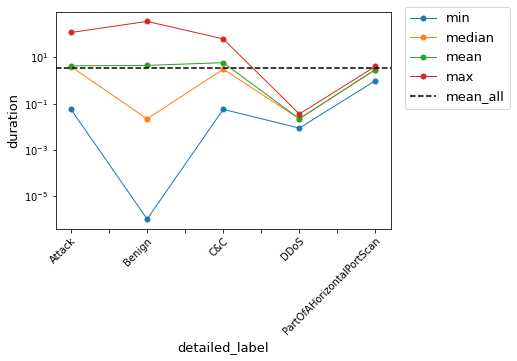

In [59]:
# Check some statistical quantities for the entries where the duration is not missing as a function of the detailed labels.

# Group by detailed label and get duration
df = data_df.groupby('detailed_label')['duration']

# Get stats values by detailed label
df.min().plot(lw=1, marker=".", markersize=10, label='min')
df.median().plot(lw=1, marker=".", markersize=10, label='median')
df.mean().plot(lw=1, marker=".", markersize=10, label='mean')
df.max().plot(lw=1, marker=".", markersize=10, label='max')

# plot median from all values
plt.axhline(y = data_df['duration'].mean(), color = 'black', linestyle = '--', label='mean_all')

plt.yscale('log')
plt.xlabel('detailed_label', fontsize = 13)
plt.ylabel('duration', fontsize = 13)
plt.xticks(rotation = 90)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.05), fontsize=13)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.show()

> Since there are large fluctuations among the different type of traffic, we can replace the missing values for the duration with the mean of the non-null entries.

---
**4.1.4 Origin and response bytes**

---

> Let's check first the log transformed values of orig_ip_bytes and resp_ip_bytes when the corresponding values are missing. 

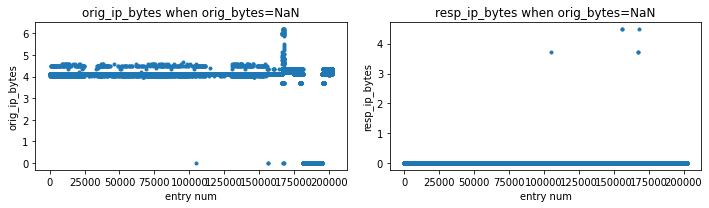

In [60]:
df = data_df.loc[data_df['orig_bytes'].isna()][['orig_ip_bytes', 'resp_ip_bytes']].copy()
df = np.log1p(df) 

fig,ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(df['orig_ip_bytes'], lw=0, marker='.')
ax[0].set_xlabel('entry num')
ax[0].set_ylabel('orig_ip_bytes')
ax[0].set_title('orig_ip_bytes when orig_bytes=NaN')

ax[1].plot(df['resp_ip_bytes'], lw=0, marker='.')
ax[1].set_xlabel('entry num')
ax[1].set_ylabel('resp_ip_bytes')
ax[1].set_title('resp_ip_bytes when orig_bytes=NaN')

plt.tight_layout()
plt.show()

> - Most of the resp_ip_bytes are 0 while most of the orig_ip_bytes have mostly values below 4-5 in their log transformed value. 
> - Let's also have a look on the relation between the ip_bytes and bytes wrt the different protocols for the non null entries of bytes.

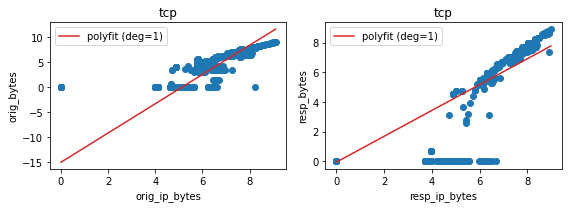

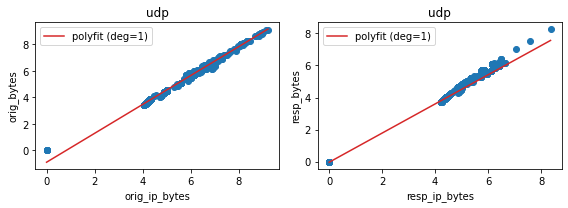

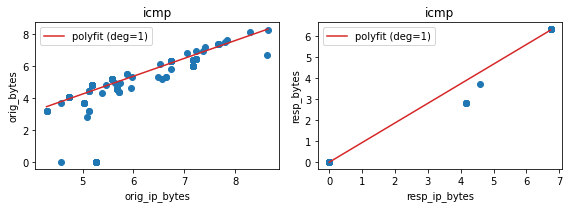

In [61]:
df = data_df.copy()


def fit_models(x, y, x_te):
    
    coefs = np.polyfit(x, y , deg=1)       
    y_predict = np.polyval(coefs, x_te)
    
    return y_predict

protocols = ['tcp', 'udp', 'icmp']

for proto in protocols:

    df_new = df.loc[(df['orig_bytes'].notna()) & (df['protocol']==proto)]
    
#     x1 = df_new['orig_ip_bytes']
#     y1 = df_new['orig_bytes']

#     x2 = df_new['resp_ip_bytes']
#     y2 = df_new['resp_bytes']

    x1 = np.log1p(df_new['orig_ip_bytes'])
    y1 = np.log1p(df_new['orig_bytes'])

    x2 = np.log1p(df_new['resp_ip_bytes'])
    y2 = np.log1p(df_new['resp_bytes'])   

    # generate x values
    x1_values = np.linspace(x1.min(), x1.max(), 100)
    y1_values = fit_models(x1, y1, x1_values)

    x2_values = np.linspace(x2.min(), x2.max(), 100)
    y2_values = fit_models(x2, y2, x2_values)    

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    ax[0].scatter(x1,y1)
    ax[0].plot(x1_values, y1_values, c='C3', label='polyfit (deg=1)')
    ax[0].set_title(proto)
    ax[0].set_xlabel('orig_ip_bytes')
    ax[0].set_ylabel('orig_bytes')
    ax[0].legend()

    ax[1].scatter(x2,y2)
    ax[1].plot(x2_values, y2_values, c='C3', label='polyfit (deg=1)')
    ax[1].set_title(proto)
    ax[1].set_xlabel('resp_ip_bytes')
    ax[1].set_ylabel('resp_bytes')    
    ax[1].legend()   

    plt.tight_layout()
    plt.show()
    

> Actually what we see from the above is the following. Data transmitted through the UDP protocol are not encapsulated within an IP frame (for e.g. an IP header or footer is not added to the UDP packets) as the the number of ip_bytes is equal to the number of bytes. However, data transmitted through the ICMP or the TCP are usually encapsulated. This means that the ip_bytes should be a bit higher than the bytes themselves. And this is what we see for the ICMP data and the TCP data coming only from the originator. For the TCP data coming from the responder since the orig_bytes are more or less equal to the number of ip_bytes it looks like the resp_bytes are already encapsulated into IP frames. 

> - The missing values for the resp_bytes can be filled in with the corresponding resp_ip_bytes. 
> - The missing values however for the orig_bytes cannot be extrapolated from a least squares polynomial fit as we will get negative values since the corresponding orig_ip_bytes are <= 6 and the intercept is negative. What we can do though is to check what is the difference between the ip_bytes and the bytes as this will give us an indication for the size of the IP header and footer. 

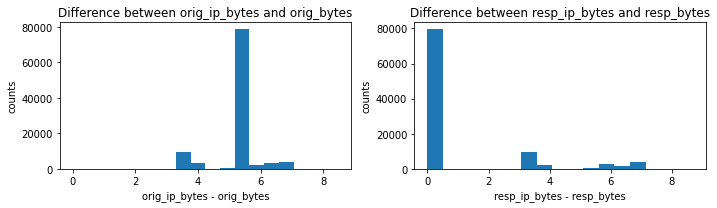

In [62]:
df = data_df.copy()
df['orig_ip_payload'] = np.where(df['orig_bytes'].isna(), np.nan, df['orig_ip_bytes']-df['orig_bytes'])
df['resp_ip_payload'] = np.where(df['resp_bytes'].isna(), np.nan, df['resp_ip_bytes']-df['resp_bytes'])

fig,ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(np.log1p(df['orig_ip_payload']), bins=18)
ax[0].set_xlabel('orig_ip_bytes - orig_bytes')
ax[0].set_ylabel('counts')
ax[0].set_title('Difference between orig_ip_bytes and orig_bytes')

ax[1].hist(np.log1p(df['resp_ip_payload']), bins=17)
ax[1].set_xlabel('resp_ip_bytes - resp_bytes')
ax[1].set_ylabel('counts')
ax[1].set_title('Difference between resp_ip_bytes and resp_bytes')

plt.tight_layout()
plt.show()

> The difference between the ip_bytes and the bytes from the originator picks around 5 while the difference from the responder peaks at zero for the reason we discussed earlier. 
> - For the originator, since the ip_bytes have values between 4-6 when the corresponding bytes are missing, instead of substracted 5 and ending up with negative values we can fill in the missing entries with zeros.
> - For the responder, we can fill in the missing values with the corresponding ip_values. 

---
4.1.5 Preprocessing step for correcting the rest of the missing values. 

---

In [63]:
# Define next preprocessing step for missing values
def preprocess_step6(input_df):
    
    # Get a copy of the dataframe
    df = input_df.copy()
    
    df['duration'] = df['duration'].fillna(df['duration'].mean())
    df['history'] = df['history'].fillna('no_history')   
    df['orig_bytes'] = df['orig_bytes'].fillna(0)
    df['resp_bytes'] = df['resp_bytes'].fillna(df['resp_ip_bytes'])    
    
    top_orig_ipv6 = df['origin_address'][(df['origin_address'].str.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")!= True)].mode()[0]
    df['origin_address'] = df['origin_address'].fillna(top_orig_ipv6)        
        
    return df

In [64]:
# process dataframe
data_df = preprocess_step6(data_df)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202613 entries, 0 to 202612
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         202613 non-null  datetime64[ns]
 1   origin_address    202613 non-null  object        
 2   origin_port       202613 non-null  int64         
 3   response_address  202613 non-null  object        
 4   response_port     202613 non-null  int64         
 5   protocol          202613 non-null  object        
 6   duration          202613 non-null  float64       
 7   orig_bytes        202613 non-null  float64       
 8   resp_bytes        202613 non-null  float64       
 9   conn_state        202613 non-null  object        
 10  history           202613 non-null  object        
 11  orig_pkts         202613 non-null  int64         
 12  orig_ip_bytes     202613 non-null  int64         
 13  resp_pkts         202613 non-null  int64         
 14  resp

---
#### **4.2 Further investigation for the PartOfAHorizontalScan entries**
---

> In order to be able to properly visualize the IP addresses we can convert them to binaries.   

In [65]:
# Import ipaddress lib
import ipaddress

# Define preprocessing step for IP addresses
def preprocess_step7(input_df):
    
    # Get a copy of the dataframe
    df = input_df.copy()
    
    
    # Get full IP address especially for IPv6
    df['origin_address'] = df.apply(lambda row: ipaddress.ip_address(row.origin_address).exploded, axis = 1)
    df['response_address'] = df.apply(lambda row: ipaddress.ip_address(row.response_address).exploded, axis = 1)
    
    # Add feature for the version of the IP
    df['ip_version'] = df.apply(lambda row: ipaddress.ip_address(row.response_address).version, axis = 1)
    
    # Add new columns for binary IP addresses
    df['response_address_int'] = np.nan
    df['origin_address_int'] = np.nan
    
    # Add binary
    mask = df.loc[df['ip_version']==4].index
    df.loc[mask, 'origin_address_int'] = df.iloc[mask].apply(lambda row: int(ipaddress.IPv4Address(row.origin_address)), axis = 1)    
    df.loc[mask, 'response_address_int'] = df.iloc[mask].apply(lambda row: int(ipaddress.IPv4Address(row.response_address)), axis = 1) 
    
    mask = df.loc[df['ip_version']==6].index
    df.loc[mask, 'origin_address_int'] = df.iloc[mask].apply(lambda row: int(ipaddress.IPv6Address(row.origin_address)), axis = 1)    
    df.loc[mask, 'response_address_int'] = df.iloc[mask].apply(lambda row: int(ipaddress.IPv6Address(row.response_address)), axis = 1)    
    
    # Change data type
    df['origin_address_int'] = df['origin_address_int'].astype('float')
    df['response_address_int'] = df['response_address_int'].astype('float')    
    
    return df

In [66]:
# process dataframe
data_df = preprocess_step7(data_df)

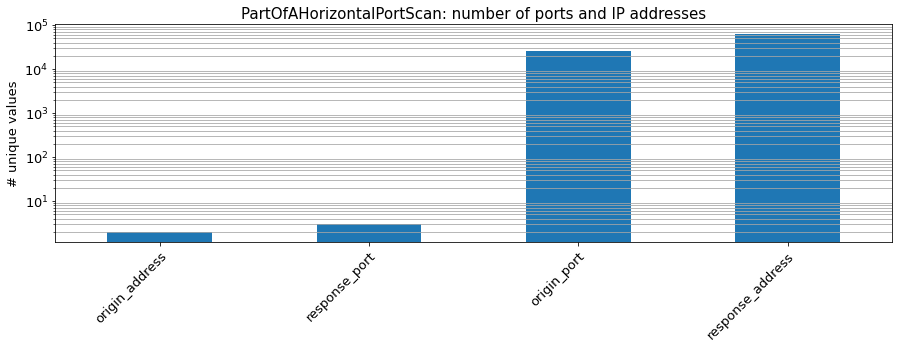

In [67]:
# Define features to check
cols = ['origin_address', 'origin_port', 'response_address', 'response_port']
    
# Check unique values per numerical feature
data_df[cols].loc[data_df['detailed_label']=='PartOfAHorizontalPortScan'].nunique().sort_values().plot.bar(logy=True, 
                                                                         figsize=(15, 4), 
                                                                         fontsize=13)
plt.grid(True, which="minor", ls="-", color='0.65')  
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.ylabel('# unique values', fontsize=13)
plt.title('PartOfAHorizontalPortScan: number of ports and IP addresses', fontsize=15)
plt.show()

> For the detailed label PartOfAHorizontalPortScan there are:
>  - 2 unique entries for the feature: origin_address
>  - 3 unique entries for the feature: response_port  
>  - ~26,000 unique entries for the feature: origin_port
>  - ~60,000 unique entries for the feature: response_address

In [68]:
# Display frequencies from origin IP addresses and response ports
df = data_df.loc[data_df['detailed_label']=='PartOfAHorizontalPortScan']
df[['origin_address', 'response_port']].value_counts()

origin_address  response_port
192.168.2.5     22               122302
                59353             23295
192.168.1.195   63798               111
dtype: int64

> We can check now the response addresses and origin ports with the above pairs of origin_address and response_port.

origin_address: 192.168.2.5 , response_port: 22 

Number of entries: 122302 

Number of unique values:
origin_port         25093
response_address    61765
dtype: int64


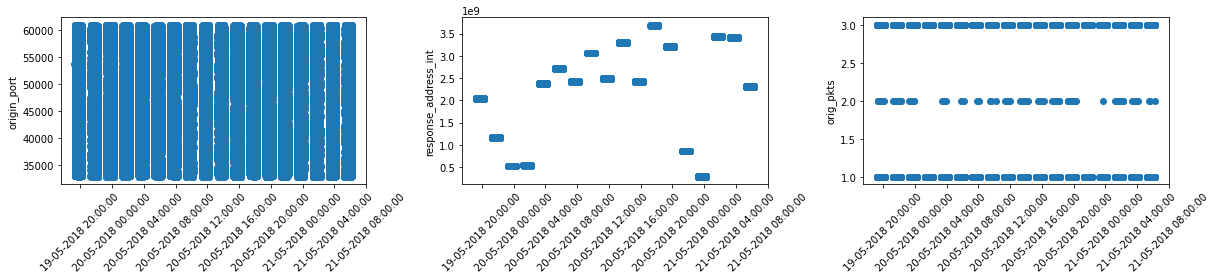

origin_address: 192.168.2.5 , response_port: 59353 

Number of entries: 23295 

Number of unique values:
origin_port         10317
response_address        1
dtype: int64


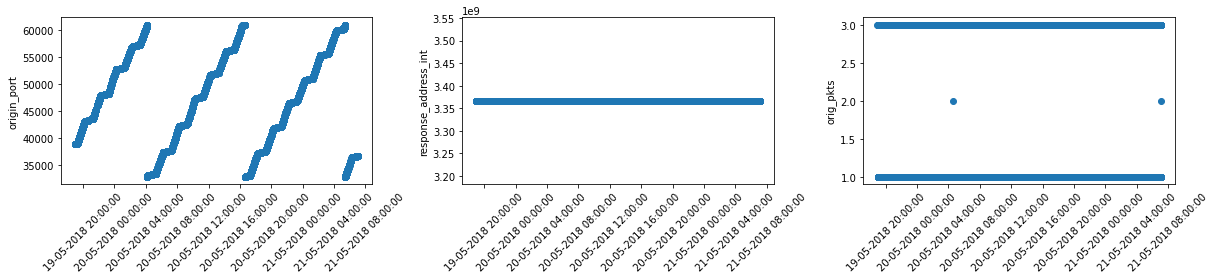

origin_address: 192.168.1.195 , response_port: 63798 

Number of entries: 111 

Number of unique values:
origin_port         105
response_address      1
dtype: int64


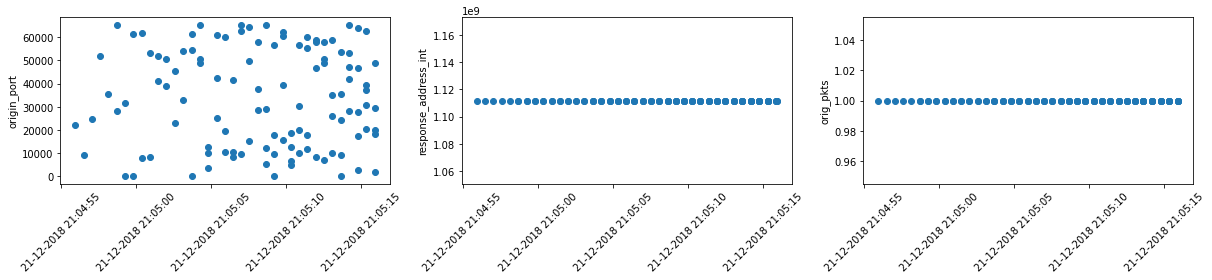

In [69]:
import matplotlib.dates as mdates

origin_addresses = ['192.168.2.5', '192.168.2.5', '192.168.1.195']
response_ports  = [22, 59353, 63798]

x_cols = ['timestamp', 'timestamp', 'timestamp']
y_cols = ['origin_port', 'response_address_int', 'orig_pkts']

for orig_add, resp_port  in zip(origin_addresses, response_ports):

    df = data_df.loc[(data_df['detailed_label']=='PartOfAHorizontalPortScan') &
                     (data_df['origin_address']==orig_add) &
                     (data_df['response_port']==resp_port)]

    print('origin_address:', orig_add , ', response_port:' , resp_port, '\n')
    print('Number of entries:', df.shape[0], '\n')
    print('Number of unique values:')
    print(df[['origin_port', 'response_address']].nunique())
    
    fig, axes = plt.subplots(1, 3, figsize=(17, 4))
    
    for xcol, ycol, ax in zip(x_cols, y_cols, axes.ravel()):    
        
        ax.scatter(df[xcol], df[ycol])
        #ax.set_title('Origin_address:'+ str(orig_add) + '\n response_port:' + str(resp_port))
        ax.set_ylabel(ycol)
        ax.tick_params(axis='x', labelrotation = 45)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M:%S'))    
         
    
    plt.tight_layout()
    plt.show()
    
    

> - From the plots in the 1st row we see 11 distinct captures. For each one, at a first glance, it seems that there is single response address and different ports, but this is not the case as there are 61,765 unique response addresses instead of 11 and 25,093 unique origin ports. Since the number of origin ports are much less than the number of response addresses this suggests horizontal scan ports OR a mixture of horizontal and vertical scans in those entries. 
> - From the plots in the 2nd and 3rd row and the number of unique values of the response addresses and ports, it's more clear that these scans are vertical and not horizontal. 
> - From the first 2 rows we also see that the number of packets send from the originator are either 1 or 3. We can verify if the different packets are send to the same port or on different ports by looking few entries from the 2nd plot. 

In [70]:
data_df.loc[(data_df['detailed_label']=='PartOfAHorizontalPortScan') &
            (data_df['origin_address']=='192.168.2.5') & 
            (data_df['response_port']==59353)].head(10)

,timestamp,origin_address,origin_port,response_address,response_port,protocol,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,detailed_label,ip_version,response_address_int,origin_address_int
4,2018-05-19 18:57:41.866499901,192.168.2.5,38792,200.168.87.203,59353,tcp,2.998333,0.0,0.0,S0,S,3,180,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
5,2018-05-19 18:57:48.874876022,192.168.2.5,38792,200.168.87.203,59353,tcp,3.509105,0.0,0.0,S0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
6,2018-05-19 18:57:52.877722025,192.168.2.5,38793,200.168.87.203,59353,tcp,2.997182,0.0,0.0,S0,S,3,180,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
8,2018-05-19 18:57:59.884958982,192.168.2.5,38793,200.168.87.203,59353,tcp,3.509105,0.0,0.0,S0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
9,2018-05-19 18:58:03.888751030,192.168.2.5,38794,200.168.87.203,59353,tcp,2.996286,0.0,0.0,S0,S,3,180,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
10,2018-05-19 18:58:10.895039082,192.168.2.5,38794,200.168.87.203,59353,tcp,3.509105,0.0,0.0,S0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
11,2018-05-19 18:58:14.899768829,192.168.2.5,38795,200.168.87.203,59353,tcp,2.995263,0.0,0.0,S0,S,3,180,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
12,2018-05-19 18:58:21.905126095,192.168.2.5,38795,200.168.87.203,59353,tcp,3.509105,0.0,0.0,S0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
13,2018-05-19 18:58:25.905906916,192.168.2.5,38796,200.168.87.203,59353,tcp,2.999262,0.0,0.0,S0,S,3,180,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09
14,2018-05-19 18:58:32.915181160,192.168.2.5,38796,200.168.87.203,59353,tcp,3.509105,0.0,0.0,S0,S,1,60,0,0,Malicious,PartOfAHorizontalPortScan,4,3.366476e+09,3.232236e+09


> From the same origin port there are two different number of packets send. 

---
Events coming from the origin address 192.168.2.5 and the response port 22.

---

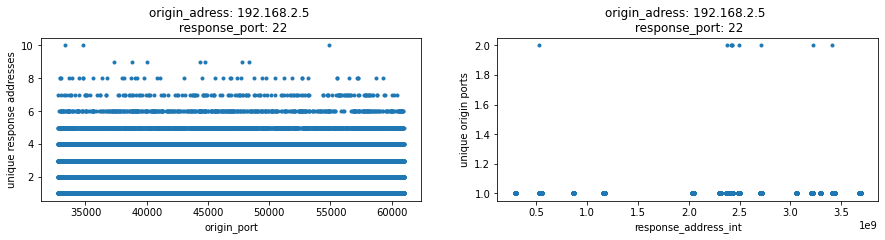

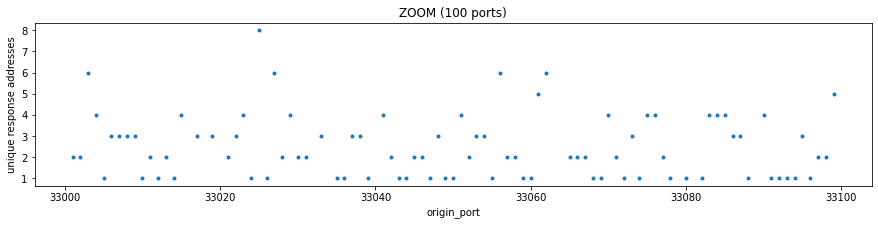

In [71]:
# Check unique values
df = data_df.loc[(data_df['detailed_label']=='PartOfAHorizontalPortScan') &
                 (data_df['origin_address']=='192.168.2.5') & 
                 (data_df['response_port']==22)]

_title = 'origin_adress: 192.168.2.5 \n response_port: 22'

fig, ax = plt.subplots(1, 2, figsize=(15, 3))
df.groupby('origin_port')['response_address'].nunique().plot(lw=0, marker=".", title = _title, 
                                                             ylabel='unique response addresses', ax=ax[0])
df.groupby('response_address_int')['origin_port'].nunique().plot(lw=0, marker=".", title = _title, 
                                                             ylabel='unique origin ports', ax=ax[1])

plt.show()

#### Zoom of 1st plot
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
df.loc[(df['origin_port']>33000) & (df['origin_port']<33100)].groupby('origin_port')['response_address'].nunique().plot(lw=0, marker=".", 
                                                                                                                        title = 'ZOOM (100 ports)', 
                                                                                                                        ylabel='unique response addresses',
                                                                                                                        ax=ax)

plt.show()

> From the above we see that:
> - for each origin port there might be 1 or 2 or ... or 10 unique response addresses and 
> - for each response address there might be 1 or 2 different origin ports 

> One could assume that when for a single origin port there are more than 1 response addresses these are horizontal scans, while when the response address is equal to 1 these are vertical scans. However is not very clear for those events if correction is needed. We can have a look though, how some captures as a function of the timestamp look like assuming that there is a mixture of horizontal and vertical scans. 

---
Zoom on captures from the origin address 192.168.2.5 and the response port 22.

---

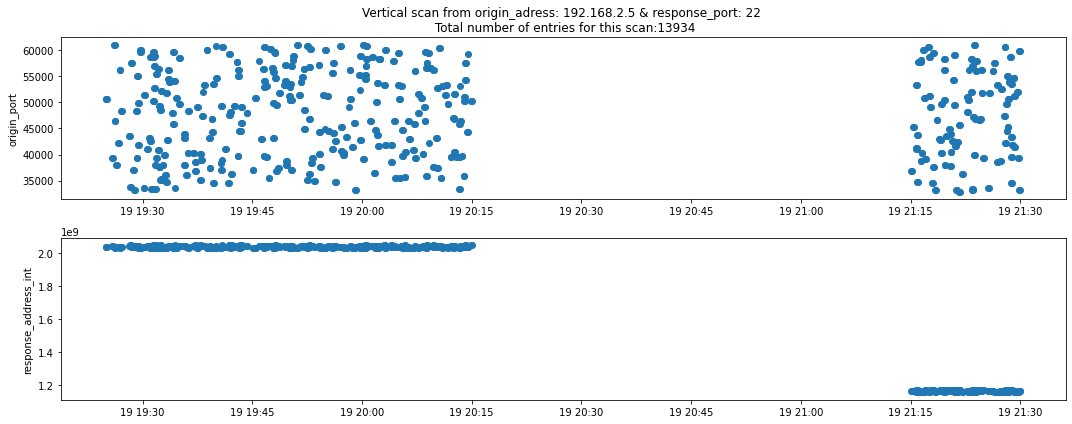

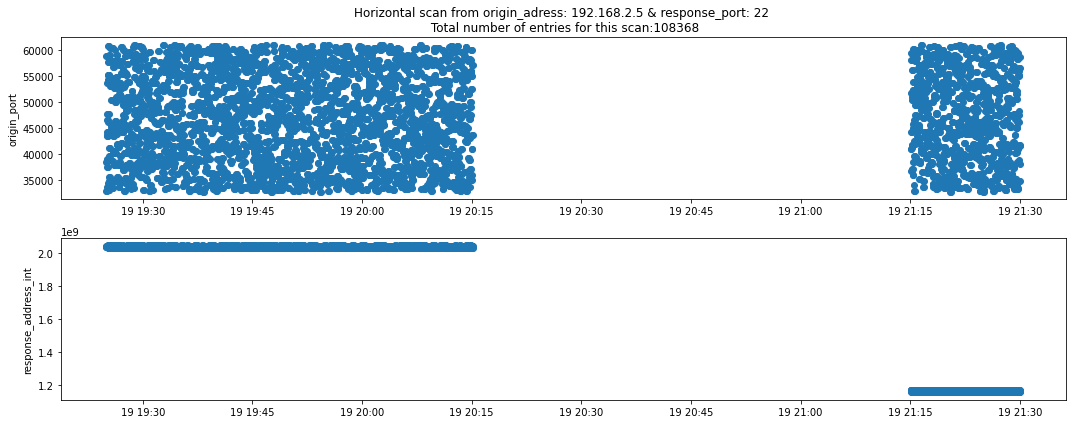

In [72]:
df = data_df.loc[(data_df['detailed_label']=='PartOfAHorizontalPortScan') &
                 (data_df['origin_address']=='192.168.2.5') & 
                 (data_df['response_port']==22)]


df_uniques = df.groupby('origin_port')['response_address_int'].nunique().to_frame().reset_index()


####### Vertical scan (same host, different port) ######

# Get a list of ports for response_addresses that appear only once
ls_single_response_addresses = df_uniques.loc[df_uniques['response_address_int']==1]['origin_port'].to_list()

# Get the entries with the ports from the list ls_single_response_addresses and zoom in the timestamp to get a single capture
df2 = df[df['origin_port'].isin(ls_single_response_addresses)]
nentries = df2.shape[0]
df2 = df2.loc[(df2['timestamp']>='2018-05-19 19:25') & (df2['timestamp']<='2018-05-19 21:30')]

# Get subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 6))

_title = 'Vertical scan from origin_adress: 192.168.2.5 & response_port: 22 \n Total number of entries for this scan:' + str(nentries)

ax[0].scatter(df2['timestamp'], df2['origin_port'])
ax[0].set_ylabel('origin_port')
ax[0].set_title(_title)

ax[1].scatter(df2['timestamp'], df2['response_address_int'])
ax[1].set_ylabel('response_address_int')
plt.tight_layout()
plt.show()

####### Horizontal scan (same port, different hosts) ######

# Get a list of ports for response_addresses that appear only once
ls_response_addresses = df_uniques.loc[df_uniques['response_address_int']>1]['origin_port'].to_list()

# Get the entries with the ports from the listls_single_response_addresses and zoom in the timestamp to get a single capture
df2 = df[df['origin_port'].isin(ls_response_addresses)]
nentries = df2.shape[0]
df2 = df2.loc[(df2['timestamp']>='2018-05-19 19:25') & (df2['timestamp']<='2018-05-19 21:30')]

# Get suplots
fig, ax = plt.subplots(2, 1, figsize=(15, 6))

_title = 'Horizontal scan from origin_adress: 192.168.2.5 & response_port: 22 \n Total number of entries for this scan:' + str(nentries)

ax[0].scatter(df2['timestamp'], df2['origin_port'])
ax[0].set_ylabel('origin_port')
ax[0].set_title(_title)

ax[1].scatter(df2['timestamp'], df2['response_address_int'])
ax[1].set_ylabel('response_address_int')
plt.tight_layout()
plt.show()

> Both captures look quite similar. 

---
#### **4.3 Preprocessing step**
---

In [73]:
# Define preprocessing step to correct the scans
def preprocess_step8(input_df, first_correction=False, second_correction=False):
    
    # Get a copy of the dataframe
    df = input_df.copy()

    # First correction
    if first_correction==True:
    
        origin_addresses = ['192.168.2.5', '192.168.1.195']
        response_ports  = [59353, 63798]

        for orig_add, resp_port in zip(origin_addresses, response_ports):

            mask = df.loc[(df['detailed_label']=='PartOfAHorizontalPortScan') &
                          (df['origin_address']==orig_add) &
                          (df['response_port']==resp_port)].index

            df.loc[mask, 'detailed_label'] = 'PartOfAVerticalPortScan'

    # Second (possible) correction
    if second_correction==True:           
    
        df_uniques = df.loc[(df['detailed_label']=='PartOfAHorizontalPortScan') &
                               (df['origin_address']=='192.168.2.5') &
                               (df['response_port']==22)].groupby('origin_port')['response_address_int'].nunique().to_frame().reset_index()


        # Get a list of ports for response_addresses that appear only once
        ls_ = df_uniques.loc[df_uniques['response_address_int']==1]['origin_port'].to_list()   

        mask = df[df['origin_port'].isin(ls_)].index
        df.loc[mask, 'detailed_label'] = 'PartOfAVerticalPortScan'
    

    return df

---
#### **4.4 Check number of entries per detailed label after correcting port scans**
---

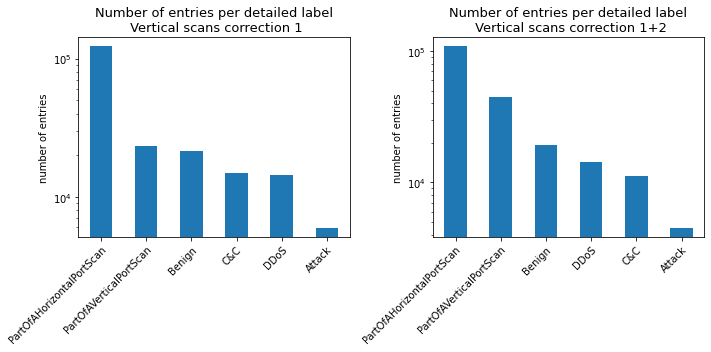

In [74]:
delme_df1 = data_df.copy()
delme_df2 = data_df.copy()

# Preprocess data
delme_df1 = preprocess_step8(data_df, first_correction=True, second_correction=False)
delme_df2 = preprocess_step8(data_df, first_correction=True, second_correction=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot number of entries per detailed label
delme_df1['detailed_label'].value_counts().plot.bar(ax=ax[0])
ax[0].set_title('Number of entries per detailed label\n Vertical scans correction 1', fontsize=13)

delme_df2['detailed_label'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title('Number of entries per detailed label\n Vertical scans correction 1+2', fontsize=13)

for i in range(0,2):
    ax[i].set_ylabel('number of entries')
    ax[i].set_yscale('log')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 45, ha='right', rotation_mode='anchor')

plt.tight_layout()    
plt.show()

> If disentangling the horizontal from the vertical scans will not "confuse" the classifiers there will be ~1e5 labels corresponding to horizontal scans and:
> - ~2e4 vertical scans with the 1st correction where the response IP addresses are unique
> - ~5e4 vertical scans with the 1st and the 2nd correction 

<div class="alert alert-block alert-success">
<b>Summary from the invertigation of missing values and the entries labeled as PartOfAHorizontalScanPort</b> 
<hr>

- The replacement of the missing entries is relatively straight forward. 
- From the investigation of the entries labeled as PartOfAHorizontalScanPort there is an evidence that part of them are vertical scans. Further investigation in combination with some classifiers is needed to be sure if those corrections are useful or not.
</div>

---
### **5. Additional feature engineering**
---

As the dataframe contains now the encoding of the IP addresses as integers, we can have a look how the pearson correlation looks like by factorizing all the rest of the categorical features. 

---
#### **5.1 Correlation among all features and target**
---

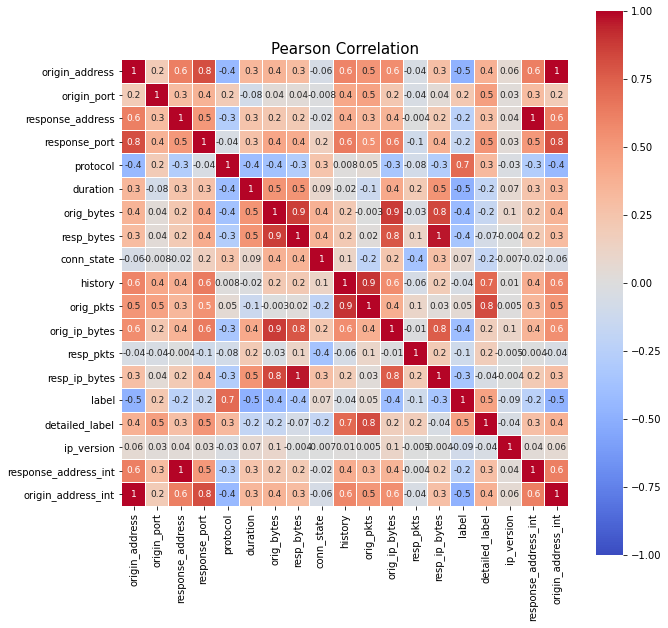

In [75]:
df = data_df.drop(['timestamp'], axis=1).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
#mask_ut=np.triu(np.ones(df.shape)).astype(np.bool)

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df, #mask=mask_ut,
                 xticklabels=True,
                 yticklabels=True,
                 square=True,
                 cmap='coolwarm',
                 linewidths=0.05,
                 vmin=-1, vmax=1,
                 annot=True, annot_kws={"size": 9}, fmt='.1g')
ax.set_title('Pearson Correlation',fontsize= 15)
plt.show()

> The target (detailed_label) has:
> - a **high correlation** of 0.7-0.8 with the *history* and *orig_pkts* respectively
> - a **medium to low correlation** (0.3-0.5) with the *origin_address, orig_port, response_address, response_port* and *protocol*
> - a **small anti-correlation** of 0.2 with the *duration, orig_bytes* and *conn_state*

> The numeric representation of the *origin* and *response IP addresses* has a correlation of 0.4 and 0.3 respectively with the target value. 

---
#### **5.2 Add binary features from the ipaddress library**

---

In [76]:
# Copy processed dataframe
data_df2 = data_df.copy()

data_df2['origin_is_private'] = data_df2.apply(lambda row: ipaddress.ip_address(row.origin_address).is_private, axis = 1)
data_df2['origin_is_global'] = data_df2.apply(lambda row: ipaddress.ip_address(row.origin_address).is_global, axis = 1)
data_df2['origin_is_unspecified'] = data_df2.apply(lambda row: ipaddress.ip_address(row.origin_address).is_unspecified, axis = 1)
data_df2['origin_is_reserved'] = data_df2.apply(lambda row: ipaddress.ip_address(row.origin_address).is_reserved, axis = 1)
data_df2['origin_is_loopback'] = data_df2.apply(lambda row: ipaddress.ip_address(row.origin_address).is_loopback, axis = 1)
data_df2['origin_is_multicast'] = data_df2.apply(lambda row: ipaddress.ip_address(row.origin_address).is_multicast, axis = 1)
data_df2['origin_is_link_local'] = data_df2.apply(lambda row: ipaddress.ip_address(row.origin_address).is_link_local, axis = 1)

data_df2['response_is_private'] = data_df2.apply(lambda row: ipaddress.ip_address(row.response_address).is_private, axis = 1)
data_df2['response_is_global'] = data_df2.apply(lambda row: ipaddress.ip_address(row.response_address).is_global, axis = 1)
data_df2['response_is_unspecified'] = data_df2.apply(lambda row: ipaddress.ip_address(row.response_address).is_unspecified, axis = 1)
data_df2['response_is_reserved'] = data_df2.apply(lambda row: ipaddress.ip_address(row.response_address).is_reserved, axis = 1)
data_df2['response_is_loopback'] = data_df2.apply(lambda row: ipaddress.ip_address(row.response_address).is_loopback, axis = 1)
data_df2['response_is_multicast'] = data_df2.apply(lambda row: ipaddress.ip_address(row.response_address).is_multicast, axis = 1)
data_df2['response_is_link_local'] = data_df2.apply(lambda row: ipaddress.ip_address(row.response_address).is_link_local, axis = 1)

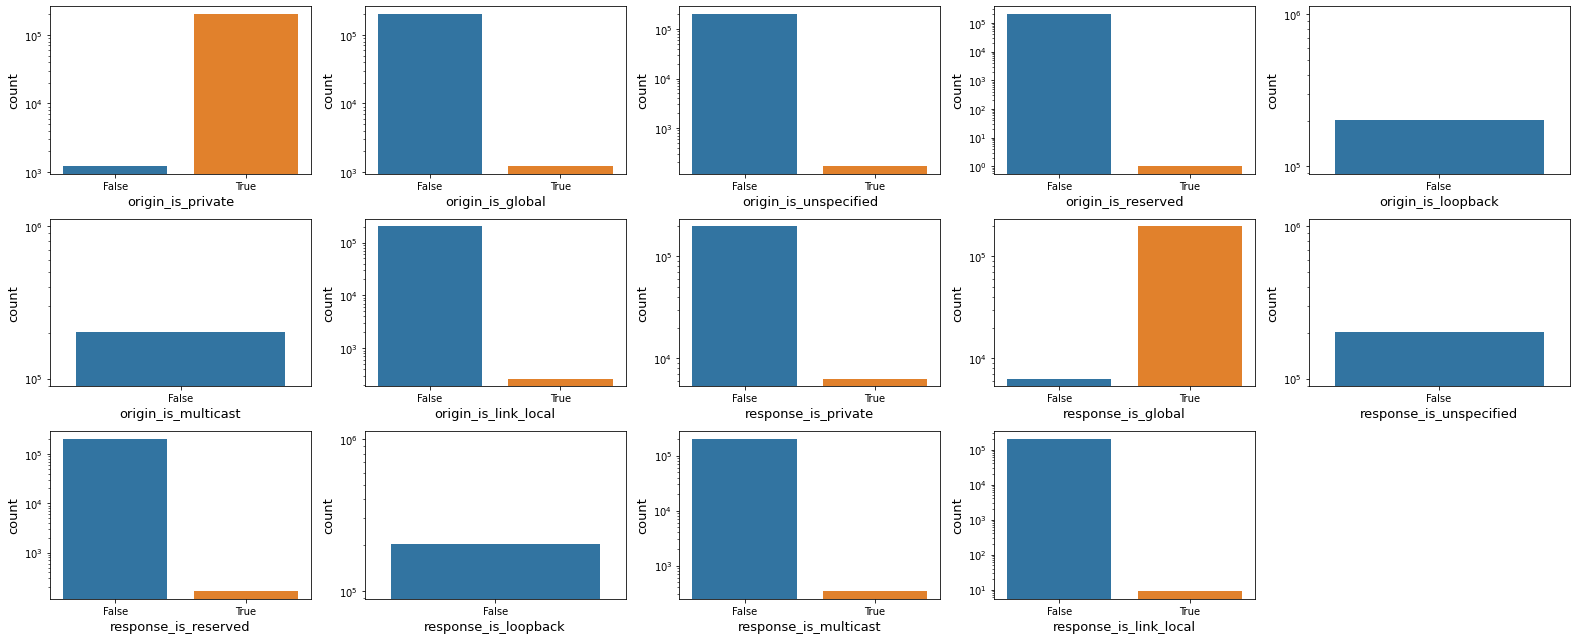

In [77]:
# Get new features into a list
cols_to_plot = []
for col in data_df2.columns:
    if (col.startswith('origin_is') | col.startswith('response_is')):
        cols_to_plot.append(col)

# Create subplots        
fig, ax = plt.subplots(3, 5, figsize=(22, 9))

for col, subplot in zip(cols_to_plot, ax.flatten()):
    sns.countplot(x=data_df2[col], ax=subplot)
    #ax.plot(data_df2[col])
    subplot.set_yscale('log')
    subplot.set_xlabel(col, fontsize=13)
    subplot.set_ylabel('count', fontsize=13)

ax.flat[-1].set_visible(False)# Don't saw last empty plot       
plt.tight_layout()
plt.show()    

> There are some features with only False values that are not very useful but the others might be correlated with other features or the target.

---
#### **5.3 Encoding of IP addresses**

---

> According to E.Shao<a id = "ref_1">[1]</a>, the best way of encoding IP addresses for network intrusion detection is to split them in pairs of bits. For e.g. the 32bit address address 192.168.1.1 will become 4 different features (x1=192, x2=168, x3=1, x4=1) each one containing 8 bit. We can encode also the IP addresses in this way and check afterwards the pearson correlation. At this point, the IPv6 addresses which are in total 211 will be dropped since they will create 4 additional features with 0 values for all the IPv4 addresses.


> [[1]](#ref_1) Shao, Enchun (2019): Encoding IP Address as a Feature for Network Intrusion Detection. Purdue University Graduate School. Thesis. https://doi.org/10.25394/PGS.11307287.v1 

In [78]:
# Drop IPv6 addresses
data_df2 = data_df2.drop(data_df2.loc[data_df2['ip_version']==6].index, axis=0)
print('Number of entries with IPv6 addresses:',data_df.shape[0] - data_df2.shape[0])
print('Final number of entries:', data_df2.shape[0])

Number of entries with IPv6 addresses: 211
Final number of entries: 202402


In [79]:
# Define function to split the addresses
def encode_address(X_df, col, prefix):

    # Split IP address
    X_df[col] = X_df[col].apply(lambda x: x.split('.'))

    # Gets octades
    X_df[prefix + '_oct1'] = X_df[col].apply(lambda x: x[0]).astype(np.float64)
    X_df[prefix + '_oct2'] = X_df[col].apply(lambda x: x[1]).astype(np.float64)
    X_df[prefix + '_oct3'] = X_df[col].apply(lambda x: x[2]).astype(np.float64)
    X_df[prefix + '_oct4'] = X_df[col].apply(lambda x: x[3]).astype(np.float64)

    # Remove original column
    X_df = X_df.drop(col, axis=1)

    return X_df

In [80]:
data_df2 = encode_address(data_df2, 'origin_address', 'origin_address')
data_df2 = encode_address(data_df2, 'response_address', 'response_address')

---
#### **5.4 Pearson correlation containing the added features**

---

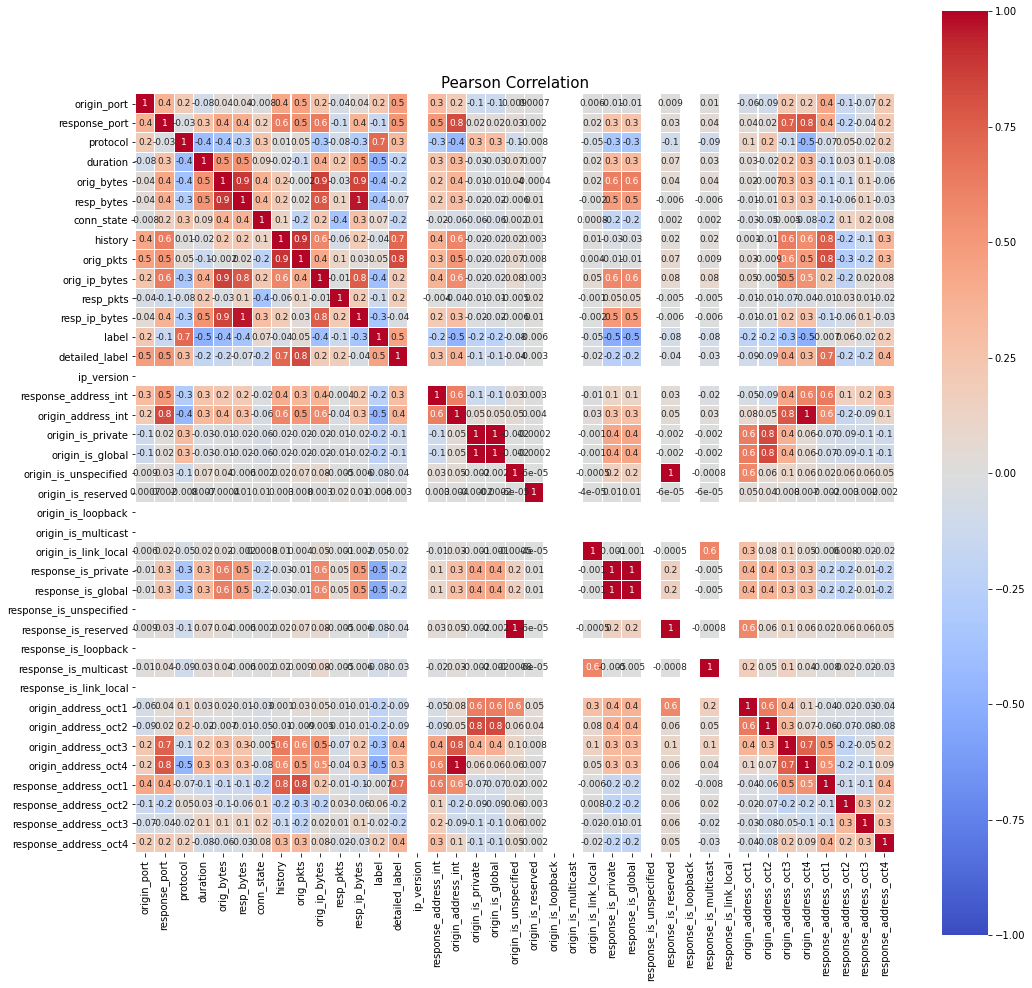

In [81]:
df = data_df2.drop(['timestamp'], axis=1).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
#mask_ut=np.triu(np.ones(df.shape)).astype(np.bool)

fig, ax = plt.subplots(figsize=(17, 17))
ax = sns.heatmap(df, #mask=mask_ut,
                 xticklabels=True,
                 yticklabels=True,
                 square=True,
                 cmap='coolwarm',
                 linewidths=0.05,
                 vmin=-1, vmax=1,
                 annot=True, annot_kws={"size": 9}, fmt='.1g')
ax.set_title('Pearson Correlation',fontsize= 15)
fig.savefig('pearson.png', dpi=200) 
plt.show()

<div class="alert alert-block alert-success">
<b>Summary for the additional feature engineering</b> 
<hr>

- The only features from the ipaddress library which have a small anticorrelation with the target value (detailed_label) are the:
 - *origin_is_private* and *origin_is_global* with an anticorrelation of 0.1 and the
 - *response_is_private* and *response_is_global* with an anticorrelation of 0.2
    
    
-  After splitting the IPv4 addresses into octets, the features:
 - *origin_address_oct3*  
 - *response_address_oct1* 
 - *response_address_oct4* 
    
   have a medium to high correlation of 0.3-0.7 with the target value, while the other octets have a small anticorrelation of ~0.1-0.2.   
</div>

---
### **6. Summary**
---

> **In general:**

> - From the initial 23 features, 8 of them need to be dropped (3  with only null values, 1 with ~90% of missing values, uid, timestamp, label, missed_bytes).
> - The replacement of missing entries is straight forward to be implemented while dublicate entries are not easy to be identified due to the nature of the data. 
> - Further tests are needed for the entries labeled as PartOfAHorizontalScan, if the corrections that were identified will not confuse the classifiers. These tests will be performed in the next notebook together with the different encoding of the categorical features as well as the addition or not of the binary features mentioned earlier. 


> **Entries that need to be dropped:**
> - the 3 type of malware captures with less than 50 entries (C&C-Torii, C&C-FileDownload and FileDownload) in order for the classifiers to not be ill-conditioning after splitting  the dataset for training, validation and test. 
> - the 211 benign entries with IPv6 addresses because:
>   - their integer trasformation results in huge numbers or
>   - if they are to be transformed into octets, the 4 additional octets that need to be added for those addresses will contain only zeros for the IPv4 addresses.
> - The outliers of the numerical features which are in total 105 entries.

> As there are some entries that overlap from the above combinations only **152 entries** will be dropped in the end. This new dataset will be saved in order to be used in the next notebook. 

---
### **7. Create new dataset without the IPv6 addresses and the 3 small classes**
---

In [82]:
# import utils
import utils.data_reducer as dr

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Save new dataset in a csv file
data_df = pd.read_csv(os.path.join('data', 'ioT_data.csv'))
print('Initial shape of dataset:', data_df.shape)

data_df_reduced = dr.drop_entries(data_df)
print('Final shape of dataset after dropping entries:', data_df_reduced.shape)

Initial shape of dataset: (202765, 23)
Final shape of dataset after dropping entries: (202402, 23)
